# Pure Data-Driven F1 Tire Degradation Model

## Philosophy
This notebook takes a **purely data-driven approach** - no hard-coded assumptions about which compounds are faster or how degradation should behave. We let the data speak for itself, even if results are counterintuitive, and focus on explaining *why* the data shows what it shows.

---

## Section 1: Data Loading & Initial Exploration

### 1.1 Load Raw Data
- Load the pre-processed lap data from `F1_TireDeg_Analysis.ipynb` (the `full_combined_data` variable)
- Alternatively, re-run the FastF1 data fetching for selected races
- Load `circuit.csv` for track metadata

### 1.2 Initial Data Quality Check
- Count total laps by compound (C1-C5)
- Identify missing values in key columns
- Check for outliers in lap times (safety cars, red flags, pit laps)

### 1.3 Visualization: Raw Data Overview
- **Histogram**: Distribution of `TyreLife` by compound
- **Box plot**: Lap times by compound (to see raw speed differences)
- **Scatter plot**: All lap times vs TyreLife, colored by compound

**Purpose**: Understand what data we actually have before making any modeling decisions.

---

## Section 2: Data Scope Limitations

### 2.1 Define Reliable Data Ranges
For each compound, determine the maximum `TyreLife` where we have sufficient data (≥20 samples):

| Compound | Max Reliable TyreLife | Rationale |
|----------|----------------------|-----------|
| C5 | ~15 laps | Teams pit early on soft tires |
| C4 | ~20 laps | Moderate stint lengths |
| C3 | ~25 laps | Medium compound, longer stints |
| C2 | ~30 laps | Hard compound, extended runs |
| C1 | ~35 laps | Hardest compound, longest stints |

### 2.2 Visualization: Data Availability Heatmap
- Create a heatmap showing sample count for each (compound, TyreLife) combination
- Clearly mark the "reliable zone" vs "sparse/extrapolation zone"

### 2.3 Filter Dataset
- **Training data**: Only include laps within reliable ranges
- **No extrapolation**: Model will refuse to predict beyond observed data

**Key Decision**: We explicitly limit predictions to where we have data, rather than extrapolating and hoping.

---

## Section 3: Feature Engineering (Data-Driven Only)

### 3.1 Target Variable: `delta_from_fresh`
- For each stint, calculate the driver's lap 1-3 average as their "fresh tire baseline"
- Target = `lap_time_fuel_corrected` - `fresh_baseline`
- This removes car/driver differences and isolates tire effect

### 3.2 Features (No Hard-Coded Compound Rankings)
| Feature | Source | Notes |
|---------|--------|-------|
| `TyreLife` | FastF1 | Primary degradation driver |
| `compound` | FastF1 | **One-hot encoded**, not ordinal - let model learn relationships |
| `dirty_air` | Calculated | Gap to car ahead (0-1 scale) |
| `TrackTemp` | FastF1 | Track temperature |
| `AirTemp` | FastF1 | Air temperature |
| `Tyre Stress` | circuit.csv | Circuit characteristic |
| `Asphalt Abrasion` | circuit.csv | Surface wear factor |
| `Lateral` | circuit.csv | Cornering load |
| `Downforce` | circuit.csv | Aero load on tires |

### 3.3 What We're NOT Doing
- ❌ No `compound_speed` encoding (would impose our assumptions)
- ❌ No `TyreLife²` term (would force non-linear degradation)
- ❌ No interaction terms that encode physics assumptions

**Philosophy**: Let the model discover patterns, don't tell it what to find.

---

## Section 4: Train/Test Split Strategy

### 4.1 Split Options

**Option A: Random Split (80/20)**
- Simple, maximizes training data
- Risk: Data leakage if same stint appears in train and test

**Option B: Stint-Based Split**
- Keep entire stints together (all laps from one driver's stint in same set)
- Prevents leakage, tests generalization to new stints
- **Recommended approach**

**Option C: Race-Based Split**
- Hold out 2-3 entire races for testing
- Tests generalization to completely new events
- Most rigorous but may reduce training data significantly

### 4.2 Recommended Approach
1. Group data by `stint_key` (Driver + Race + StintNumber)
2. Randomly assign 80% of *stints* to training, 20% to test
3. All laps from a stint stay together

### 4.3 Stratification
- Ensure each compound has proportional representation in train/test
- May need to oversample rare compounds (C1, C2) in test set

---

## Section 5: Model Training

### 5.1 Model Choice: Random Forest Regressor
**Why Random Forest over Gradient Boosting:**
- More interpretable feature importances
- Less prone to overfitting on noisy data
- Handles one-hot encoded compounds naturally

### 5.2 Hyperparameters (Start Simple)
- `n_estimators`: 100
- `max_depth`: 10 (prevent overfitting)
- `min_samples_leaf`: 20 (ensure predictions are based on sufficient data)

### 5.3 Training Process
1. Fit model on training stints
2. Record feature importances
3. Generate predictions on test set

### 5.4 Per-Compound Models (Alternative)
- Train 5 separate models, one per compound
- Avoids compound comparison issues entirely
- Each model only predicts degradation for its compound

---

## Section 6: Model Validation

### 6.1 Overall Metrics
- **R²**: How much variance explained (expect 0.10-0.20 for this noisy data)
- **RMSE**: Prediction error in seconds
- **MAE**: Average absolute error

### 6.2 Per-Compound Validation
For each compound separately:
- Calculate R², RMSE
- Compare predicted vs actual degradation at key tire life points (lap 5, 10, 15)
- Flag if a compound has poor predictions

### 6.3 Residual Analysis
- Plot residuals vs TyreLife (should be random, no pattern)
- Plot residuals vs predicted value (check for heteroscedasticity)
- Identify systematic biases

### 6.4 Sanity Checks
- Does degradation generally increase with TyreLife? (It should, but don't force it)
- Are predictions within physically reasonable bounds (0-5 seconds delta)?

---

## Section 7: Visualizations - Raw Data

### 7.1 Actual Stint Degradation Curves
- For each compound, plot 20-30 random actual stints
- X-axis: TyreLife, Y-axis: delta_from_fresh
- Show the **noise and variation** in real data
- Use transparency to show overlapping stints

### 7.2 Mean ± Standard Deviation by TyreLife
- For each compound, calculate mean and std of delta at each TyreLife
- Plot as line with shaded confidence band
- Shows both trend and uncertainty

### 7.3 Compound Comparison (Raw Data)
- Side-by-side box plots of delta_from_fresh at specific TyreLife values (5, 10, 15, 20)
- Let the data show which compounds degrade more/less
- May reveal counterintuitive results (explain why!)

### 7.4 Circuit Effects
- Faceted plots showing degradation curves for different circuits
- Highlight high-degradation vs low-degradation tracks

---

## Section 8: Visualizations - Model Predictions

### 8.1 Predicted vs Actual Scatter
- Each point is one lap
- Perfect model = 45° line
- Color by compound to see if some compounds fit better

### 8.2 Predicted Degradation Curves
- For each compound, plot model's predicted delta at TyreLife 1-max
- **Show only within reliable data range** (dotted line beyond)
- Overlay with actual data points

### 8.3 Feature Importance Plot
- Bar chart of feature importances from Random Forest
- Which features actually matter?
- Does `TyreLife` dominate? Do circuit features contribute?

### 8.4 Uncertainty Visualization
- Use Random Forest's tree variance to show prediction intervals
- Wider intervals where we have less data
- Honest about what we know vs don't know

---

## Section 9: Interpretation & Explanation

### 9.1 Explaining Counterintuitive Results
If C1 appears to degrade more than C5:
- **Explanation**: We observe C1 for 35 laps, C5 for only 15 laps
- C5 would degrade more *if* we saw it for 35 laps, but we don't have that data
- The measured degradation rate (ms/lap) is more meaningful than total degradation

### 9.2 What the Model Actually Learned
- Summarize key findings from feature importances
- Which circuit characteristics matter most?
- How much does dirty air affect degradation?

### 9.3 Limitations Acknowledgment
- Explicitly state where predictions are reliable vs uncertain
- Document what questions the data can/cannot answer

---

## Section 10: Outputs & Artifacts

### 10.1 Save Model
- Export trained model as `.joblib` file
- Save feature list and reliable prediction ranges

### 10.2 Export Data
- Save processed training data as CSV
- Save prediction results with confidence intervals

### 10.3 Generate Report
- Summary statistics for each compound
- Key visualizations as PNG files
- Markdown summary of findings

---

## Summary: Key Differences from Physics-Informed Approach

| Aspect | Physics-Informed | Pure Data-Driven |
|--------|------------------|------------------|
| Compound encoding | Ordinal (C5=5, C1=1) | One-hot (no ranking) |
| Degradation shape | Forced quadratic | Whatever data shows |
| Monotonicity | Enforced in post-processing | Not enforced |
| Predictions beyond data | Extrapolates | Refuses/warns |
| Results | "Sensible" but may not match reality | Honest but may be counterintuitive |

**The goal is truth, not comfort.** If the data shows something unexpected, we explain why rather than hiding it.

In [2]:
import fastf1
import fastf1.plotting
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Suppress warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')

print("F1 Tire Degradation Analysis Environment Ready! 🏎️")

F1 Tire Degradation Analysis Environment Ready! 🏎️


In [3]:
def calculate_gaps_to_car_ahead(laps):
    """
    Calculate gaps to car ahead for each lap based on position and timing data.
    This replicates the gap calculation logic for dirty air analysis.
    
    Parameters:
    - laps: FastF1 laps dataframe (raw session.laps)
    
    Returns:
    - DataFrame with gap columns added: Start_Gap, S1_Gap, S2_Gap, S3_Gap, Avg_Gap
    """
    # Work with a copy to avoid modifying original
    laps_with_gaps = laps.copy()
    
    # Add LapTimeSeconds if not present
    if 'LapTimeSeconds' not in laps_with_gaps.columns:
        laps_with_gaps['LapTimeSeconds'] = laps_with_gaps['LapTime'].dt.total_seconds()
    
    # Get accurate laps for creating the "car ahead" reference
    accurate_laps_for_ahead = laps_with_gaps[laps_with_gaps['IsAccurate'] == True].copy()
    
    # Create car_ahead dataframe with timing data
    car_ahead = accurate_laps_for_ahead[['LapStartTime', 'Position', 'LapNumber', 
                                       'Sector1SessionTime', 'Sector2SessionTime', 
                                       'Sector3SessionTime']].copy()
    
    # Create merge key for car ahead (position + 1 = car we're following)
    car_ahead['MergeKey'] = car_ahead['Position'] + 1
    
    # Rename columns to indicate they're for the car ahead
    car_ahead.rename(columns={
        'LapStartTime': 'Start_Ahead', 
        'Sector1SessionTime': 'S1_Ahead', 
        'Sector2SessionTime': 'S2_Ahead', 
        'Sector3SessionTime': 'S3_Ahead'
    }, inplace=True)
    
    # Merge with main laps data to get car ahead timing
    laps_with_gaps = laps_with_gaps.merge(
        car_ahead, 
        left_on=['Position', 'LapNumber'], 
        right_on=['MergeKey', 'LapNumber'], 
        how='left'
    )
    
    # Calculate gaps in seconds
    laps_with_gaps['Start_Gap'] = (laps_with_gaps['LapStartTime'] - laps_with_gaps['Start_Ahead']).dt.total_seconds()
    laps_with_gaps['S1_Gap'] = (laps_with_gaps['Sector1SessionTime'] - laps_with_gaps['S1_Ahead']).dt.total_seconds()
    laps_with_gaps['S2_Gap'] = (laps_with_gaps['Sector2SessionTime'] - laps_with_gaps['S2_Ahead']).dt.total_seconds()
    laps_with_gaps['S3_Gap'] = (laps_with_gaps['Sector3SessionTime'] - laps_with_gaps['S3_Ahead']).dt.total_seconds()
    
    # Calculate average gap across sectors
    laps_with_gaps['Avg_Gap'] = (laps_with_gaps['S1_Gap'] + laps_with_gaps['S2_Gap'] + laps_with_gaps['S3_Gap']) / 3
    
    # Clean up negative gaps (when we're ahead of the reference car)
    laps_with_gaps.loc[laps_with_gaps['Start_Gap'] < 0, 'Start_Gap'] = np.nan
    laps_with_gaps.loc[laps_with_gaps['S1_Gap'] < 0, 'S1_Gap'] = np.nan
    laps_with_gaps.loc[laps_with_gaps['S2_Gap'] < 0, 'S2_Gap'] = np.nan
    laps_with_gaps.loc[laps_with_gaps['S3_Gap'] < 0, 'S3_Gap'] = np.nan
    
    return laps_with_gaps


def compute_dirty_air_feature(df, gap_col='Start_Gap'):
    """
    Convert gap (seconds) to a dirty-air feature using the Start_Gap column.
    We use a smooth transform: small gaps -> strong dirty-air penalty.
    Returns 'dirty_air' where higher = worse (more lap time lost).
    
    Parameters:
    - df: DataFrame with gap data
    - gap_col: Column name for gap data (default 'Start_Gap')
    
    Returns:
    - DataFrame with 'dirty_air' column added (0-1 scale, 1=worst penalty)
    """
    out = df.copy()
    # Use the Start_Gap column that was calculated earlier, or fall back to provided gap_col
    if 'Start_Gap' in out.columns:
        g = out['Start_Gap'].fillna(999.0)  # No car ahead -> large gap (clean air)
    elif gap_col in out.columns:
        g = out[gap_col].fillna(999.0)
    else:
        raise ValueError(f"Neither 'Start_Gap' nor '{gap_col}' found in dataframe")
    
    # Example transform: inverse gap up to a clamp
    clamp = 5.0   # gaps > clamp treated as "clean air"
    g_clamped = np.minimum(g, clamp)
    # Inverse with smoothness; shift to 0..1
    out['dirty_air'] = 1.0 - (g_clamped / clamp) # 1 = bumper-to-bumper, 0 = >clamp clean
    #out['dirty_air'] = (1.0 - (g_clamped / clamp)) ** 2       Test later power transform for more non-linearity
    return out


def fuel_correct_lap_time(df, total_fuel_load=95, fuel_pace_adjustment=0.03, lap_time_col='LapTimeSeconds'):
    """
    Subtract estimated fuel-related time from lap_time based on race progression.
    Assumes steady fuel burn from total_fuel_load kg to ~5kg at race end.
    
    Parameters:
    - df: DataFrame with lap time data
    - total_fuel_load: Starting fuel load in kg (default 95kg, ending ~5kg = 90kg burned)
    - fuel_pace_adjustment: Time loss per kg of fuel (default 0.03s/kg)
    - lap_time_col: Column name for lap times in seconds
    
    Returns:
    - DataFrame with 'fuel_load', 'fuel_time_loss', and 'lap_time_fuel_corrected' columns
    """
    out = df.copy()
    
    # Calculate fuel load based on lap progression within each driver's stint
    # Group by driver to handle each driver separately
    def calculate_fuel_for_driver(driver_df):
        driver_df = driver_df.copy()
        lap_count = len(driver_df)
        
        # Calculate fuel per lap (90kg burned over race distance)
        fuel_per_lap = total_fuel_load / lap_count if lap_count > 0 else 0
        
        # Fuel load decreases linearly: starts high, ends low
        # Create fuel load based on remaining laps (reverse order)
        remaining_laps = np.arange(lap_count, 0, -1)
        driver_df['fuel_load'] = remaining_laps * fuel_per_lap + 5  # +5kg minimum fuel
        
        return driver_df
    
    # Apply fuel calculation per driver
    if 'Driver' in out.columns:
        out = out.groupby('Driver', group_keys=False).apply(calculate_fuel_for_driver)
    else:
        # If no driver column, treat as single driver
        lap_count = len(out)
        fuel_per_lap = 90 / lap_count if lap_count > 0 else 0
        remaining_laps = np.arange(lap_count, 0, -1)
        out['fuel_load'] = remaining_laps * fuel_per_lap + 5
    
    # Calculate time loss due to fuel weight
    out['fuel_time_loss'] = out['fuel_load'] * fuel_pace_adjustment
    
    # Create fuel-corrected lap time
    if lap_time_col not in out.columns:
        # Try to create LapTimeSeconds if LapTime exists
        if 'LapTime' in out.columns:
            out['LapTimeSeconds'] = out['LapTime'].dt.total_seconds()
        else:
            raise ValueError(f"Column '{lap_time_col}' not found and cannot create it")
    
    out['lap_time_fuel_corrected'] = out[lap_time_col] - out['fuel_time_loss']
    
    return out


def filter_clean_laps(df, is_accurate_col='IsAccurate', min_speed=80.0, speed_col='AverageSpeed'):
    """
    Filter laps to only include "clean" laps for analysis.
    
    Criteria:
    - is_accurate_col == True (excludes outlaps, safety car, etc.)
    - speed_col >= min_speed (if column exists)
    
    Parameters:
    - df: DataFrame with lap data
    - is_accurate_col: Column name for accuracy flag
    - min_speed: Minimum average speed threshold
    - speed_col: Column name for speed data
    
    Returns:
    - Filtered DataFrame with only clean laps
    """
    out = df.copy()
    
    # Always filter by accuracy
    mask = (out[is_accurate_col] == True)
    
    # Add speed filter if column exists
    if speed_col in out.columns:
        mask = mask & (out[speed_col] >= min_speed)
    
    return out[mask]


def process_race_for_tire_analysis(session, include_weather=True):
    """
    Complete pipeline to process a race session for tire degradation analysis.
    Takes raw session and returns clean laps with all corrections applied.
    
    This is the main function that combines all the processing steps.
    
    Parameters:
    - session: FastF1 session object (already loaded with session.load())
    - include_weather: Whether to merge weather data (default True)
    
    Returns:
    - DataFrame ready for tire degradation analysis with columns:
      * lap_time_fuel_corrected: Fuel-corrected lap times
      * dirty_air: Dirty air penalty feature (0-1)
      * fuel_load: Calculated fuel load per lap
      * Start_Gap, S1_Gap, etc.: Gap timing to car ahead
      * Weather data (if available): TrackTemp, AirTemp, etc.
    """
    print("🏎️  Processing race data for tire analysis...")
    
    # Step 1: Get raw laps
    laps = session.laps.copy()
    print(f"📊 Starting with {len(laps)} total laps")
    
    # Step 2: Calculate gaps to car ahead
    print("⏱️  Calculating gaps to car ahead...")
    laps = calculate_gaps_to_car_ahead(laps)
    
    # Step 3: Merge weather data if available and requested
    if include_weather and hasattr(session, 'weather_data') and session.weather_data is not None:
        print("🌡️  Merging weather data...")
        laps = laps.sort_values(by='Time')
        weather_data = session.weather_data.sort_values(by='Time')
        laps = pd.merge_asof(laps, weather_data, left_on='Time', right_on='Time', direction='nearest')
    
    # Step 4: Filter to clean laps only
    print("🧹 Filtering to clean laps...")
    laps = filter_clean_laps(laps)
    print(f"✅ After filtering: {len(laps)} clean laps")
    
    # Step 5: Apply fuel correction
    print("⛽ Applying fuel corrections...")
    laps = fuel_correct_lap_time(laps)
    
    # Step 6: Add dirty air feature
    print("💨 Computing dirty air features...")
    laps = compute_dirty_air_feature(laps)
    
    print("🎉 Processing complete!")
    print(f"📈 Final dataset: {len(laps)} laps from {laps['Driver'].nunique()} drivers")
    
    return laps

print("✅ All functions loaded successfully!")

✅ All functions loaded successfully!


In [4]:
def merge_circuit_data(processed_laps, circuit_data_csv_path, year=2024):
    """
    Merge circuit-specific data (tire compounds, track characteristics) with processed lap data.
    
    This function combines FastF1 race data with external circuit information to add:
    - Exact tire compound specifications (C1-C5 instead of SOFT/MEDIUM/HARD)
    - Circuit characteristics (length, traction, grip, etc.)
    
    Parameters:
    - processed_laps: DataFrame from process_race_for_tire_analysis()
    - circuit_data_csv_path: Path to CSV file with circuit data
    - year: Year to filter circuit data (default 2024)
    
    Returns:
    - DataFrame with circuit data merged for each lap
    """
    print(f"🔗 Merging circuit data from {circuit_data_csv_path}...")
    
    # Load circuit data
    try:
        circuit_data = pd.read_csv(circuit_data_csv_path)
        print(f"📊 Loaded circuit data: {len(circuit_data)} circuits")
    except FileNotFoundError:
        print(f"❌ Circuit data file not found: {circuit_data_csv_path}")
        return processed_laps
    
    # Filter to specified year
    if 'year' in circuit_data.columns:
        circuit_data = circuit_data[circuit_data['year'] == year]
        print(f"📅 Filtered to {year}: {len(circuit_data)} circuits")
    
    # Create a copy to work with
    laps_with_circuits = processed_laps.copy()
    
    # Get unique race events from processed laps
    if 'EventName' in laps_with_circuits.columns:
        race_events = laps_with_circuits['EventName'].unique()
        print(f"🏁 Races in processed data: {list(race_events)}")
    else:
        print("⚠️ No 'EventName' column found in processed laps")
        return processed_laps
    
    # Create mapping dictionary for race name matching
    # Common variations between FastF1 and manual naming
    race_name_mapping = {
        # FastF1 EventName -> Circuit CSV race_name variations
        'Bahrain Grand Prix': ['bahrain', 'gulf air bahrain', 'formula 1 gulf air bahrain grand prix'],
        'Saudi Arabian Grand Prix': ['saudi', 'arabia', 'jeddah', 'saudi arabian'],
        'Australian Grand Prix': ['australia', 'australian', 'melbourne'],
        'Japanese Grand Prix': ['japan', 'japanese', 'suzuka'],
        'Chinese Grand Prix': ['china', 'chinese', 'shanghai'],
        'Miami Grand Prix': ['miami', 'formula 1 crypto.com miami'],
        'Emilia Romagna Grand Prix': ['imola', 'emilia romagna', 'san marino'],
        'Monaco Grand Prix': ['monaco', 'monte carlo'],
        'Canadian Grand Prix': ['canada', 'canadian', 'montreal'],
        'Spanish Grand Prix': ['spain', 'spanish', 'catalunya', 'barcelona'],
        'Austrian Grand Prix': ['austria', 'austrian', 'red bull ring', 'spielberg'],
        'British Grand Prix': ['britain', 'british', 'silverstone', 'great britain'],
        'Hungarian Grand Prix': ['hungary', 'hungarian', 'hungaroring'],
        'Belgian Grand Prix': ['belgium', 'belgian', 'spa'],
        'Dutch Grand Prix': ['netherlands', 'dutch', 'zandvoort'],
        'Italian Grand Prix': ['italy', 'italian', 'monza'],
        'Azerbaijan Grand Prix': ['azerbaijan', 'baku'],
        'Singapore Grand Prix': ['singapore', 'marina bay'],
        'United States Grand Prix': ['usa', 'united states', 'austin', 'cota'],
        'Mexico City Grand Prix': ['mexico', 'mexican', 'mexico city'],
        'São Paulo Grand Prix': ['brazil', 'brazilian', 'sao paulo', 'interlagos'],
        'Las Vegas Grand Prix': ['vegas', 'las vegas'],
        'Qatar Grand Prix': ['qatar', 'losail'],
        'Abu Dhabi Grand Prix': ['abu dhabi', 'yas marina']
    }
    
    def find_matching_circuit(event_name, circuit_df):
        """Find matching circuit data for a given FastF1 event name."""
        event_lower = event_name.lower()
        
        # Direct match attempts
        for _, circuit_row in circuit_df.iterrows():
            race_name = str(circuit_row.get('Circuit', '')).lower()
            
            # Try exact match first
            if event_lower == race_name:
                return circuit_row
            
            # Try partial matches using mapping
            if event_name in race_name_mapping:
                for variation in race_name_mapping[event_name]:
                    if variation in race_name:
                        return circuit_row
            
            # Try reverse - check if any keyword from race_name is in event_name
            race_keywords = race_name.replace('-', ' ').split()
            for keyword in race_keywords:
                if len(keyword) > 3 and keyword in event_lower:  # Avoid short words
                    return circuit_row
        
        return None
    
    # Track successful and failed matches
    successful_matches = 0
    failed_matches = []
    
    # Process each race event
    for event_name in race_events:
        print(f"\n🔍 Processing: {event_name}")
        
        # Find matching circuit data
        matching_circuit = find_matching_circuit(event_name, circuit_data)
        
        if matching_circuit is not None:
            # Get laps for this event
            event_mask = laps_with_circuits['EventName'] == event_name
            
            # Add circuit data to all laps for this event
            for col in circuit_data.columns:
                if col not in ['EventName', 'year', 'url']:  # Skip metadata columns
                    laps_with_circuits.loc[event_mask, f'{col}'] = matching_circuit[col]
            
            # Map tire compounds to exact compounds
            # Get the compound mapping for this circuit
            soft_compound = matching_circuit.get('Soft')
            medium_compound = matching_circuit.get('Medium') 
            hard_compound = matching_circuit.get('Hard')
            
            # Create exact compound column based on tire type
            def map_compound(row):
                compound_type = row.get('Compound', '').upper()
                if compound_type == 'SOFT':
                    return soft_compound
                elif compound_type == 'MEDIUM':
                    return medium_compound
                elif compound_type == 'HARD':
                    return hard_compound
                else:
                    return compound_type  # Keep original if not standard compound
            
            # Apply compound mapping to this event's laps
            event_laps = laps_with_circuits[event_mask]
            if 'Compound' in event_laps.columns:
                laps_with_circuits.loc[event_mask, 'exact_compound'] = event_laps.apply(map_compound, axis=1)
            
            successful_matches += 1
            print(f"✅ Matched with circuit data")
            print(f"   Compounds: Soft={soft_compound}, Medium={medium_compound}, Hard={hard_compound}")
            
        else:
            failed_matches.append(event_name)
            print(f"❌ No matching circuit data found")
    
    # Summary
    print(f"\n📈 Merge Summary:")
    print(f"   ✅ Successful matches: {successful_matches}")
    print(f"   ❌ Failed matches: {len(failed_matches)}")
    
    if failed_matches:
        print(f"   Failed events: {failed_matches}")
        print(f"   💡 You may need to manually adjust race names in CSV")
    
    # Show available circuit columns
    circuit_cols = [col for col in laps_with_circuits.columns if col.startswith('circuit_')]
    if circuit_cols:
        print(f"   📊 Added circuit columns: {len(circuit_cols)}")
        print(f"   {circuit_cols[:5]}..." if len(circuit_cols) > 5 else f"   {circuit_cols}")
    
    return laps_with_circuits


print("✅ Circuit data merge function added!")

✅ Circuit data merge function added!


In [5]:
def fetch_and_process_race(year, race_identifier, session_type="R", include_weather=True):
    """
    Fetch a single race session, add event name to the data, and process for tire analysis.
    
    This function solves the problem that FastF1 session data doesn't include the event name
    as a column, which is needed for merging with circuit data.
    
    Parameters:
    - year: Year of the race (e.g., 2024)
    - race_identifier: Race identifier (e.g., "Bahrain", "Monaco", 1, 2, etc.)
    - session_type: Session type ("R" for race, "Q" for qualifying, etc.)
    - include_weather: Whether to include weather data
    
    Returns:
    - DataFrame with processed lap data including 'EventName' column
    """
    print(f"🏎️ Fetching {year} {race_identifier} {session_type}...")
    
    try:
        # Get session
        session = fastf1.get_session(year, race_identifier, session_type)
        session.load(telemetry=False, weather=include_weather)
        
        # Get the actual event name from the session
        event_name = session.event.EventName
        print(f"📅 Event name: {event_name}")
        
        # Process the race data
        processed_laps = process_race_for_tire_analysis(session, include_weather=include_weather)
        
        # Add event name to every lap
        processed_laps['EventName'] = event_name
        
        print(f"✅ Processed {len(processed_laps)} laps for {event_name}")
        return processed_laps
        
    except Exception as e:
        print(f"❌ Error processing {year} {race_identifier}: {str(e)}")
        return pd.DataFrame()  # Return empty DataFrame on error


def fetch_multiple_races(race_list, year=2024, session_type="R", include_weather=True):
    """
    Fetch and process multiple races, combining them into a single dataset.
    
    This is the main function for building multi-race datasets with event names.
    
    Parameters:
    - race_list: List of race identifiers (e.g., ["Bahrain", "Saudi Arabia", "Australia"])
    - year: Year of the races (default 2024)
    - session_type: Session type (default "R" for race)
    - include_weather: Whether to include weather data
    
    Returns:
    - Combined DataFrame with all races and EventName column for merging
    """
    print(f"🚀 Fetching {len(race_list)} races from {year}...")
    
    all_races_data = []
    successful_races = []
    failed_races = []
    
    for race_identifier in race_list:
        race_data = fetch_and_process_race(
            year=year, 
            race_identifier=race_identifier, 
            session_type=session_type,
            include_weather=include_weather
        )
        
        if not race_data.empty:
            all_races_data.append(race_data)
            successful_races.append(race_identifier)
        else:
            failed_races.append(race_identifier)
        
        print()  # Add spacing between races
    
    if all_races_data:
        # Combine all race data
        combined_data = pd.concat(all_races_data, ignore_index=True)
        
        print(f"🎉 Successfully combined data!")
        print(f"   ✅ Successful races: {len(successful_races)}")
        print(f"   ❌ Failed races: {len(failed_races)}")
        print(f"   📊 Total laps: {len(combined_data)}")
        print(f"   🏁 Events: {combined_data['EventName'].unique()}")
        
        if failed_races:
            print(f"   ⚠️ Failed races: {failed_races}")
        
        return combined_data
    else:
        print("❌ No races were successfully processed")
        return pd.DataFrame()


print("✅ Race fetching functions added!")


✅ Race fetching functions added!


In [6]:
races_2024 = [
    "Bahrain", "Saudi Arabia", "Australia", "Japan", "China",
    "Miami", "Emilia Romagna", "Monaco", "Canada", "Spain",
    "Austria", "Great Britain", "Hungary", "Belgium", "Netherlands",
    "Italy", "Azerbaijan", "Singapore", "United States", "Mexico",
    "Brazil", "Las Vegas", "Qatar", "Abu Dhabi"
]

In [7]:
full_season_data = fetch_multiple_races(races_2024, year=2024)
full_combined_data = merge_circuit_data(full_season_data, 'circuit.csv', year=2024)
full_combined_data.head()

req         WARNING 	DEFAULT CACHE ENABLED! (1.47 GB) /Users/emccauley6/Library/Caches/fastf1


🚀 Fetching 24 races from 2024...
🏎️ Fetching 2024 Bahrain R...


core           INFO 	Loading data for Bahrain Grand Prix - Race [v3.6.1]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req      

📅 Event name: Bahrain Grand Prix
🏎️  Processing race data for tire analysis...
📊 Starting with 1129 total laps
⏱️  Calculating gaps to car ahead...
🌡️  Merging weather data...
🧹 Filtering to clean laps...
✅ After filtering: 1024 clean laps
⛽ Applying fuel corrections...
💨 Computing dirty air features...
🎉 Processing complete!
📈 Final dataset: 1024 laps from 20 drivers
✅ Processed 1024 laps for Bahrain Grand Prix

🏎️ Fetching 2024 Saudi Arabia R...


req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '11', '16', '81', '14', '63', '38', '4', '44', '27', '23', '20', '31', '2', '22', '3', '77', '24', '18', '10']
core           INFO 	Finished loading data for 20 drivers: ['1', '11', '16', '81', '14', '63', '38', '4', '44', '27', '23', '20', '31', '2', '22', '3', '77', '24', '18', '10']
core           INFO 	Loading data for Australian Grand Prix - Race [v3.6.1]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
core           INFO 	Loading data for Australian Grand Prix - Race [v3.6.1]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Usin

📅 Event name: Saudi Arabian Grand Prix
🏎️  Processing race data for tire analysis...
📊 Starting with 901 total laps
⏱️  Calculating gaps to car ahead...
🌡️  Merging weather data...
🧹 Filtering to clean laps...
✅ After filtering: 816 clean laps
⛽ Applying fuel corrections...
💨 Computing dirty air features...
🎉 Processing complete!
📈 Final dataset: 816 laps from 19 drivers
✅ Processed 816 laps for Saudi Arabian Grand Prix

🏎️ Fetching 2024 Australia R...


req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 19 drivers: ['55', '16', '4', '81', '11', '18', '22', '14', '27', '20', '23', '3', '10', '77', '24', '31', '63', '44', '1']
core           INFO 	Finished loading data for 19 drivers: ['55', '16', '4', '81', '11', '18', '22', '14', '27', '20', '23', '3', '10', '77', '24', '31', '63', '44', '1']
core           INFO 	Loading data for Japanese Grand Prix - Race [v3.6.1]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
core           INFO 	Loading data for Japanese Grand Prix - Race [v3.6.1]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data 

📅 Event name: Australian Grand Prix
🏎️  Processing race data for tire analysis...
📊 Starting with 998 total laps
⏱️  Calculating gaps to car ahead...
🌡️  Merging weather data...
🧹 Filtering to clean laps...
✅ After filtering: 857 clean laps
⛽ Applying fuel corrections...
💨 Computing dirty air features...
🎉 Processing complete!
📈 Final dataset: 857 laps from 19 drivers
✅ Processed 857 laps for Australian Grand Prix

🏎️ Fetching 2024 Japan R...


req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '11', '55', '16', '4', '14', '63', '81', '44', '22', '27', '18', '20', '77', '31', '10', '2', '24', '3', '23']
core           INFO 	Finished loading data for 20 drivers: ['1', '11', '55', '16', '4', '14', '63', '81', '44', '22', '27', '18', '20', '77', '31', '10', '2', '24', '3', '23']
core           INFO 	Loading data for Chinese Grand Prix - Race [v3.6.1]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
core           INFO 	Loading data for Chinese Grand Prix - Race [v3.6.1]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cach

📅 Event name: Japanese Grand Prix
🏎️  Processing race data for tire analysis...
📊 Starting with 907 total laps
⏱️  Calculating gaps to car ahead...
🌡️  Merging weather data...
🧹 Filtering to clean laps...
✅ After filtering: 785 clean laps
⛽ Applying fuel corrections...
💨 Computing dirty air features...
🎉 Processing complete!
📈 Final dataset: 785 laps from 18 drivers
✅ Processed 785 laps for Japanese Grand Prix

🏎️ Fetching 2024 China R...


req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
req            INFO 	Using cached data for race_control_messages
core        WARNING 	Driver 1 completed the race distance 00:08.313000 before the recorded end of the session.
core        WARNING 	Driver 1 completed the race distance 00:08.313000 before the recorded end of the session.
core           INFO 	Finished loading data for 20 drivers: ['1', '4', '11', '16', '55', '63', '14', '81', '44', '27', '31', '23', '10', '24', '18', '20', '2', '3', '22', '77']
core           INFO 	Finished loading data for 20 drivers: ['1', '4', '11', '16', '55', '63', '14', '81', '44', '27', '31', '23', '10', '24', '18', '20', '2', '3', '22', '77']
core           INFO 	Loading data for Miami Grand Prix - Race [v3.6.1]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
core           INFO 	Loading data for Miami Grand Prix - R

📅 Event name: Chinese Grand Prix
🏎️  Processing race data for tire analysis...
📊 Starting with 1032 total laps
⏱️  Calculating gaps to car ahead...
🌡️  Merging weather data...
🧹 Filtering to clean laps...
✅ After filtering: 762 clean laps
⛽ Applying fuel corrections...
💨 Computing dirty air features...
🎉 Processing complete!
📈 Final dataset: 762 laps from 20 drivers
✅ Processed 762 laps for Chinese Grand Prix

🏎️ Fetching 2024 Miami R...


req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['4', '1', '16', '11', '55', '44', '22', '63', '14', '31', '27', '10', '81', '24', '3', '77', '18', '23', '20', '2']
core           INFO 	Finished loading data for 20 drivers: ['4', '1', '16', '11', '55', '44', '22', '63', '14', '31', '27', '10', '81', '24', '3', '77', '18', '23', '20', '2']
core           INFO 	Loading data for Emilia Romagna Grand Prix - Race [v3.6.1]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
core           INFO 	Loading data for Emilia Romagna Grand Prix - Race [v3.6.1]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            IN

📅 Event name: Miami Grand Prix
🏎️  Processing race data for tire analysis...
📊 Starting with 1111 total laps
⏱️  Calculating gaps to car ahead...
🌡️  Merging weather data...
🧹 Filtering to clean laps...
✅ After filtering: 934 clean laps
⛽ Applying fuel corrections...
💨 Computing dirty air features...
🎉 Processing complete!
📈 Final dataset: 934 laps from 20 drivers
✅ Processed 934 laps for Miami Grand Prix

🏎️ Fetching 2024 Emilia Romagna R...


req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '4', '16', '81', '55', '44', '63', '11', '18', '22', '27', '20', '3', '31', '24', '10', '2', '77', '14', '23']
core           INFO 	Finished loading data for 20 drivers: ['1', '4', '16', '81', '55', '44', '63', '11', '18', '22', '27', '20', '3', '31', '24', '10', '2', '77', '14', '23']
core           INFO 	Loading data for Monaco Grand Prix - Race [v3.6.1]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
core           INFO 	Loading data for Monaco Grand Prix - Race [v3.6.1]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached

📅 Event name: Emilia Romagna Grand Prix
🏎️  Processing race data for tire analysis...
📊 Starting with 1238 total laps
⏱️  Calculating gaps to car ahead...
🌡️  Merging weather data...
🧹 Filtering to clean laps...
✅ After filtering: 1164 clean laps
⛽ Applying fuel corrections...
💨 Computing dirty air features...
🎉 Processing complete!
📈 Final dataset: 1164 laps from 20 drivers
✅ Processed 1164 laps for Emilia Romagna Grand Prix

🏎️ Fetching 2024 Monaco R...


req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['16', '81', '55', '4', '63', '1', '44', '22', '23', '10', '14', '3', '77', '18', '2', '24', '31', '11', '27', '20']
core           INFO 	Finished loading data for 20 drivers: ['16', '81', '55', '4', '63', '1', '44', '22', '23', '10', '14', '3', '77', '18', '2', '24', '31', '11', '27', '20']
core           INFO 	Loading data for Canadian Grand Prix - Race [v3.6.1]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
core           INFO 	Loading data for Canadian Grand Prix - Race [v3.6.1]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using ca

📅 Event name: Monaco Grand Prix
🏎️  Processing race data for tire analysis...
📊 Starting with 1237 total laps
⏱️  Calculating gaps to car ahead...
🌡️  Merging weather data...
🧹 Filtering to clean laps...
✅ After filtering: 1187 clean laps
⛽ Applying fuel corrections...
💨 Computing dirty air features...
🎉 Processing complete!
📈 Final dataset: 1187 laps from 16 drivers
✅ Processed 1187 laps for Monaco Grand Prix

🏎️ Fetching 2024 Canada R...


req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '4', '63', '44', '81', '14', '18', '3', '10', '31', '27', '20', '77', '22', '24', '55', '23', '11', '16', '2']
core           INFO 	Finished loading data for 20 drivers: ['1', '4', '63', '44', '81', '14', '18', '3', '10', '31', '27', '20', '77', '22', '24', '55', '23', '11', '16', '2']
core           INFO 	Loading data for Spanish Grand Prix - Race [v3.6.1]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
core           INFO 	Loading data for Spanish Grand Prix - Race [v3.6.1]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cach

📅 Event name: Canadian Grand Prix
🏎️  Processing race data for tire analysis...
📊 Starting with 1272 total laps
⏱️  Calculating gaps to car ahead...
🌡️  Merging weather data...
🧹 Filtering to clean laps...
✅ After filtering: 1022 clean laps
⛽ Applying fuel corrections...
💨 Computing dirty air features...
🎉 Processing complete!
📈 Final dataset: 1022 laps from 20 drivers
✅ Processed 1022 laps for Canadian Grand Prix

🏎️ Fetching 2024 Spain R...


req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
req            INFO 	Using cached data for race_control_messages
core        WARNING 	Driver 1 completed the race distance 00:00.015000 before the recorded end of the session.
core           INFO 	Finished loading data for 20 drivers: ['1', '4', '44', '63', '16', '55', '81', '11', '10', '31', '27', '14', '24', '18', '3', '77', '20', '23', '22', '2']
core        WARNING 	Driver 1 completed the race distance 00:00.015000 before the recorded end of the session.
core           INFO 	Finished loading data for 20 drivers: ['1', '4', '44', '63', '16', '55', '81', '11', '10', '31', '27', '14', '24', '18', '3', '77', '20', '23', '22', '2']
core           INFO 	Loading data for Austrian Grand Prix - Race [v3.6.1]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
core           INFO 	Loading data for Austrian Grand Pr

📅 Event name: Spanish Grand Prix
🏎️  Processing race data for tire analysis...
📊 Starting with 1310 total laps
⏱️  Calculating gaps to car ahead...
🌡️  Merging weather data...
🧹 Filtering to clean laps...
✅ After filtering: 1206 clean laps
⛽ Applying fuel corrections...
💨 Computing dirty air features...
🎉 Processing complete!
📈 Final dataset: 1206 laps from 20 drivers
✅ Processed 1206 laps for Spanish Grand Prix

🏎️ Fetching 2024 Austria R...


req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['63', '81', '55', '44', '1', '27', '11', '20', '3', '10', '16', '31', '18', '22', '23', '77', '24', '14', '2', '4']
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['63', '81', '55', '44', '1', '27', '11', '20', '3', '10', '16', '31', '18', '22', '23', '77', '24', '14', '2', '4']
events      WARNING 	Correcting user input 'Great Britain' to 'Austrian Grand Prix'
core           INFO 	Loading data for Austrian Grand Prix - Race [v3.6.1]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
events      WARNING 	Correcting user input 'Great Britain' to 'Austrian Grand Prix'
core           INFO 	Loading data for Austrian Grand Prix - Race [v3.6.1]
req            INFO 	Using cached d

📅 Event name: Austrian Grand Prix
🏎️  Processing race data for tire analysis...
📊 Starting with 1405 total laps
⏱️  Calculating gaps to car ahead...
🌡️  Merging weather data...
🧹 Filtering to clean laps...
✅ After filtering: 1269 clean laps
⛽ Applying fuel corrections...
💨 Computing dirty air features...
🎉 Processing complete!
📈 Final dataset: 1269 laps from 20 drivers
✅ Processed 1269 laps for Austrian Grand Prix

🏎️ Fetching 2024 Great Britain R...


req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['63', '81', '55', '44', '1', '27', '11', '20', '3', '10', '16', '31', '18', '22', '23', '77', '24', '14', '2', '4']
core           INFO 	Finished loading data for 20 drivers: ['63', '81', '55', '44', '1', '27', '11', '20', '3', '10', '16', '31', '18', '22', '23', '77', '24', '14', '2', '4']
core           INFO 	Loading data for Hungarian Grand Prix - Race [v3.6.1]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
core           INFO 	Loading data for Hungarian Grand Prix - Race [v3.6.1]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using 

📅 Event name: Austrian Grand Prix
🏎️  Processing race data for tire analysis...
📊 Starting with 1405 total laps
⏱️  Calculating gaps to car ahead...
🌡️  Merging weather data...
🧹 Filtering to clean laps...
✅ After filtering: 1269 clean laps
⛽ Applying fuel corrections...
💨 Computing dirty air features...
🎉 Processing complete!
📈 Final dataset: 1269 laps from 20 drivers
✅ Processed 1269 laps for Austrian Grand Prix

🏎️ Fetching 2024 Hungary R...


req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['81', '4', '44', '16', '1', '55', '11', '63', '22', '18', '14', '3', '27', '23', '20', '77', '2', '31', '24', '10']
core           INFO 	Finished loading data for 20 drivers: ['81', '4', '44', '16', '1', '55', '11', '63', '22', '18', '14', '3', '27', '23', '20', '77', '2', '31', '24', '10']
core           INFO 	Loading data for Belgian Grand Prix - Race [v3.6.1]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
core           INFO 	Loading data for Belgian Grand Prix - Race [v3.6.1]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cach

📅 Event name: Hungarian Grand Prix
🏎️  Processing race data for tire analysis...
📊 Starting with 1355 total laps
⏱️  Calculating gaps to car ahead...
🌡️  Merging weather data...
🧹 Filtering to clean laps...
✅ After filtering: 1254 clean laps
⛽ Applying fuel corrections...
💨 Computing dirty air features...
🎉 Processing complete!
📈 Final dataset: 1254 laps from 20 drivers
✅ Processed 1254 laps for Hungarian Grand Prix

🏎️ Fetching 2024 Belgium R...


core        WARNING 	Fixed incorrect tyre stint information for driver '18'
core        WARNING 	Fixed incorrect tyre stint information for driver '22'
core        WARNING 	Fixed incorrect tyre stint information for driver '22'
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['44', '81', '16', '1', '4', '55', '11', '14', '31', '3', '18', '23', '10', '20', '77', '22', '2', '27', '24', '63']
core           INFO 	Finished loading data for 20 drivers: ['44', '81', '16', '1', '4', '55', '11', '14', '31', '3', '18', '23', '10', '20', '77', '22', '2', '27', '24', '63']
core           INFO 	Loading data for Dutch Grand Prix - Race [v3.6.1]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_i

📅 Event name: Belgian Grand Prix
🏎️  Processing race data for tire analysis...
📊 Starting with 841 total laps
⏱️  Calculating gaps to car ahead...
🌡️  Merging weather data...
🧹 Filtering to clean laps...
✅ After filtering: 751 clean laps
⛽ Applying fuel corrections...
💨 Computing dirty air features...
🎉 Processing complete!
📈 Final dataset: 751 laps from 20 drivers
✅ Processed 751 laps for Belgian Grand Prix

🏎️ Fetching 2024 Netherlands R...


req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['4', '1', '16', '81', '55', '11', '63', '44', '10', '14', '27', '3', '18', '23', '31', '2', '22', '20', '77', '24']
core           INFO 	Finished loading data for 20 drivers: ['4', '1', '16', '81', '55', '11', '63', '44', '10', '14', '27', '3', '18', '23', '31', '2', '22', '20', '77', '24']
events      WARNING 	Correcting user input 'Italy' to 'Italian Grand Prix'
core           INFO 	Loading data for Italian Grand Prix - Race [v3.6.1]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
events      WARNING 	Correcting user input 'Italy' to 'Italian Grand Prix'
core           INFO 	Loading data for Italian Grand Prix - Race [v3.6.1]
req            INFO 	Using cached data for session_info

📅 Event name: Dutch Grand Prix
🏎️  Processing race data for tire analysis...
📊 Starting with 1426 total laps
⏱️  Calculating gaps to car ahead...
🌡️  Merging weather data...
🧹 Filtering to clean laps...
✅ After filtering: 1354 clean laps
⛽ Applying fuel corrections...
💨 Computing dirty air features...
🎉 Processing complete!
📈 Final dataset: 1354 laps from 20 drivers
✅ Processed 1354 laps for Dutch Grand Prix

🏎️ Fetching 2024 Italy R...


req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['16', '81', '4', '55', '44', '1', '63', '11', '23', '20', '14', '43', '3', '31', '10', '77', '27', '24', '18', '22']
core           INFO 	Finished loading data for 20 drivers: ['16', '81', '4', '55', '44', '1', '63', '11', '23', '20', '14', '43', '3', '31', '10', '77', '27', '24', '18', '22']
core           INFO 	Loading data for Azerbaijan Grand Prix - Race [v3.6.1]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
core           INFO 	Loading data for Azerbaijan Grand Prix - Race [v3.6.1]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Us

📅 Event name: Italian Grand Prix
🏎️  Processing race data for tire analysis...
📊 Starting with 1008 total laps
⏱️  Calculating gaps to car ahead...
🌡️  Merging weather data...
🧹 Filtering to clean laps...
✅ After filtering: 927 clean laps
⛽ Applying fuel corrections...
💨 Computing dirty air features...
🎉 Processing complete!
📈 Final dataset: 927 laps from 20 drivers
✅ Processed 927 laps for Italian Grand Prix

🏎️ Fetching 2024 Azerbaijan R...


req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['81', '16', '63', '4', '1', '14', '23', '43', '44', '50', '27', '10', '3', '24', '31', '77', '11', '55', '18', '22']
core           INFO 	Finished loading data for 20 drivers: ['81', '16', '63', '4', '1', '14', '23', '43', '44', '50', '27', '10', '3', '24', '31', '77', '11', '55', '18', '22']
core           INFO 	Loading data for Singapore Grand Prix - Race [v3.6.1]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
core           INFO 	Loading data for Singapore Grand Prix - Race [v3.6.1]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Usin

📅 Event name: Azerbaijan Grand Prix
🏎️  Processing race data for tire analysis...
📊 Starting with 973 total laps
⏱️  Calculating gaps to car ahead...
🌡️  Merging weather data...
🧹 Filtering to clean laps...
✅ After filtering: 881 clean laps
⛽ Applying fuel corrections...
💨 Computing dirty air features...
🎉 Processing complete!
📈 Final dataset: 881 laps from 20 drivers
✅ Processed 881 laps for Azerbaijan Grand Prix

🏎️ Fetching 2024 Singapore R...


req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['4', '1', '81', '63', '16', '44', '55', '14', '27', '11', '43', '22', '31', '18', '24', '77', '10', '3', '20', '23']
core           INFO 	Finished loading data for 20 drivers: ['4', '1', '81', '63', '16', '44', '55', '14', '27', '11', '43', '22', '31', '18', '24', '77', '10', '3', '20', '23']
events      WARNING 	Correcting user input 'United States' to 'United States Grand Prix'
core           INFO 	Loading data for United States Grand Prix - Race [v3.6.1]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
events      WARNING 	Correcting user input 'United States' to 'United States Grand Prix'
core           INFO 	Loading data for United States Grand Prix - Race [v3.6.1]
req          

📅 Event name: Singapore Grand Prix
🏎️  Processing race data for tire analysis...
📊 Starting with 1177 total laps
⏱️  Calculating gaps to car ahead...
🌡️  Merging weather data...
🧹 Filtering to clean laps...
✅ After filtering: 1109 clean laps
⛽ Applying fuel corrections...
💨 Computing dirty air features...
🎉 Processing complete!
📈 Final dataset: 1109 laps from 20 drivers
✅ Processed 1109 laps for Singapore Grand Prix

🏎️ Fetching 2024 United States R...


req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['16', '55', '1', '4', '81', '63', '11', '27', '30', '43', '20', '10', '14', '22', '18', '23', '77', '31', '24', '44']
core           INFO 	Finished loading data for 20 drivers: ['16', '55', '1', '4', '81', '63', '11', '27', '30', '43', '20', '10', '14', '22', '18', '23', '77', '31', '24', '44']
core           INFO 	Loading data for Mexico City Grand Prix - Race [v3.6.1]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
core           INFO 	Loading data for Mexico City Grand Prix - Race [v3.6.1]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO

📅 Event name: United States Grand Prix
🏎️  Processing race data for tire analysis...
📊 Starting with 1059 total laps
⏱️  Calculating gaps to car ahead...
🌡️  Merging weather data...
🧹 Filtering to clean laps...
✅ After filtering: 937 clean laps
⛽ Applying fuel corrections...
💨 Computing dirty air features...
🎉 Processing complete!
📈 Final dataset: 937 laps from 19 drivers
✅ Processed 937 laps for United States Grand Prix

🏎️ Fetching 2024 Mexico R...


req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['55', '4', '16', '44', '63', '1', '20', '81', '27', '10', '18', '43', '31', '77', '24', '30', '11', '14', '23', '22']
core           INFO 	Finished loading data for 20 drivers: ['55', '4', '16', '44', '63', '1', '20', '81', '27', '10', '18', '43', '31', '77', '24', '30', '11', '14', '23', '22']
core           INFO 	Loading data for São Paulo Grand Prix - Race [v3.6.1]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
core           INFO 	Loading data for São Paulo Grand Prix - Race [v3.6.1]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Us

📅 Event name: Mexico City Grand Prix
🏎️  Processing race data for tire analysis...
📊 Starting with 1215 total laps
⏱️  Calculating gaps to car ahead...
🌡️  Merging weather data...
🧹 Filtering to clean laps...
✅ After filtering: 1061 clean laps
⛽ Applying fuel corrections...
💨 Computing dirty air features...
🎉 Processing complete!
📈 Final dataset: 1061 laps from 18 drivers
✅ Processed 1061 laps for Mexico City Grand Prix

🏎️ Fetching 2024 Brazil R...


core        WARNING 	No lap data for driver 23
core        WARNING 	Failed to perform lap accuracy check - all laps marked as inaccurate (driver 23)
core        WARNING 	Failed to perform lap accuracy check - all laps marked as inaccurate (driver 23)
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '31', '10', '63', '16', '4', '22', '81', '30', '44', '11', '50', '77', '14', '24', '55', '43', '23', '18', '27']
core           INFO 	Finished loading data for 20 drivers: ['1', '31', '10', '63', '16', '4', '22', '81', '30', '44', '11', '50', '77', '14', '24', '55', '43', '23', '18', '27']
core           INFO 	Loading data for Las Vegas Grand Prix - Race [v3.6.1]
req            INFO 	Using cached data for session_info
req            INFO 

📅 Event name: São Paulo Grand Prix
🏎️  Processing race data for tire analysis...
📊 Starting with 1135 total laps
⏱️  Calculating gaps to car ahead...
🌡️  Merging weather data...
🧹 Filtering to clean laps...
✅ After filtering: 943 clean laps
⛽ Applying fuel corrections...
💨 Computing dirty air features...
🎉 Processing complete!
📈 Final dataset: 943 laps from 18 drivers
✅ Processed 943 laps for São Paulo Grand Prix

🏎️ Fetching 2024 Las Vegas R...


core        WARNING 	Driver 63: Lap timing integrity check failed for 2 lap(s)
core        WARNING 	Driver 44: Lap timing integrity check failed for 1 lap(s)
core        WARNING 	Driver 44: Lap timing integrity check failed for 1 lap(s)
core        WARNING 	Driver 55: Lap timing integrity check failed for 1 lap(s)
core        WARNING 	Driver 16: Lap timing integrity check failed for 2 lap(s)
core        WARNING 	Driver 55: Lap timing integrity check failed for 1 lap(s)
core        WARNING 	Driver 16: Lap timing integrity check failed for 2 lap(s)
core        WARNING 	Driver  1: Lap timing integrity check failed for 1 lap(s)
core        WARNING 	Driver  4: Lap timing integrity check failed for 1 lap(s)
core        WARNING 	Driver  1: Lap timing integrity check failed for 1 lap(s)
core        WARNING 	Driver  4: Lap timing integrity check failed for 1 lap(s)
core        WARNING 	Driver 81: Lap timing integrity check failed for 1 lap(s)
core        WARNING 	Driver 81: Lap timing integrity

📅 Event name: Las Vegas Grand Prix
🏎️  Processing race data for tire analysis...
📊 Starting with 938 total laps
⏱️  Calculating gaps to car ahead...
🌡️  Merging weather data...
🧹 Filtering to clean laps...
✅ After filtering: 826 clean laps
⛽ Applying fuel corrections...
💨 Computing dirty air features...
🎉 Processing complete!
📈 Final dataset: 826 laps from 20 drivers
✅ Processed 826 laps for Las Vegas Grand Prix

🏎️ Fetching 2024 Qatar R...


core        WARNING 	Fixed incorrect tyre stint information for driver '43'
core        WARNING 	Fixed incorrect tyre stint information for driver '31'
core        WARNING 	Fixed incorrect tyre stint information for driver '31'
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '16', '81', '63', '10', '55', '14', '24', '20', '4', '77', '44', '22', '30', '23', '27', '11', '18', '43', '31']
core           INFO 	Finished loading data for 20 drivers: ['1', '16', '81', '63', '10', '55', '14', '24', '20', '4', '77', '44', '22', '30', '23', '27', '11', '18', '43', '31']
core           INFO 	Loading data for Abu Dhabi Grand Prix - Race [v3.6.1]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for 

📅 Event name: Qatar Grand Prix
🏎️  Processing race data for tire analysis...
📊 Starting with 943 total laps
⏱️  Calculating gaps to car ahead...
🌡️  Merging weather data...
🧹 Filtering to clean laps...
✅ After filtering: 717 clean laps
⛽ Applying fuel corrections...
💨 Computing dirty air features...
🎉 Processing complete!
📈 Final dataset: 717 laps from 18 drivers
✅ Processed 717 laps for Qatar Grand Prix

🏎️ Fetching 2024 Abu Dhabi R...


req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['4', '55', '16', '44', '63', '1', '10', '27', '14', '81', '23', '22', '24', '18', '61', '20', '30', '77', '43', '11']
core           INFO 	Finished loading data for 20 drivers: ['4', '55', '16', '44', '63', '1', '10', '27', '14', '81', '23', '22', '24', '18', '61', '20', '30', '77', '43', '11']


📅 Event name: Abu Dhabi Grand Prix
🏎️  Processing race data for tire analysis...
📊 Starting with 1035 total laps
⏱️  Calculating gaps to car ahead...
🌡️  Merging weather data...
🧹 Filtering to clean laps...
✅ After filtering: 921 clean laps
⛽ Applying fuel corrections...
💨 Computing dirty air features...
🎉 Processing complete!
📈 Final dataset: 921 laps from 19 drivers
✅ Processed 921 laps for Abu Dhabi Grand Prix

🎉 Successfully combined data!
   ✅ Successful races: 24
   ❌ Failed races: 0
   📊 Total laps: 23976
   🏁 Events: ['Bahrain Grand Prix' 'Saudi Arabian Grand Prix' 'Australian Grand Prix'
 'Japanese Grand Prix' 'Chinese Grand Prix' 'Miami Grand Prix'
 'Emilia Romagna Grand Prix' 'Monaco Grand Prix' 'Canadian Grand Prix'
 'Spanish Grand Prix' 'Austrian Grand Prix' 'Hungarian Grand Prix'
 'Belgian Grand Prix' 'Dutch Grand Prix' 'Italian Grand Prix'
 'Azerbaijan Grand Prix' 'Singapore Grand Prix' 'United States Grand Prix'
 'Mexico City Grand Prix' 'São Paulo Grand Prix' 'Las Vega

,Time,Driver,DriverNumber,LapTime,LapNumber,Stint,PitOutTime,PitInTime,Sector1Time,Sector2Time,...,Hard,Traction,Tyre Stress,Asphalt Grip,Asphalt Abrasion,Track Evolution,Breaking,Lateral,Downforce,exact_compound
0,0 days 01:03:13.785000,VER,1,0 days 00:01:36.296000,2.0,1.0,NaT,NaT,0 days 00:00:30.916000,0 days 00:00:41.661000,...,C1,4.0,3.0,4.0,5.0,4.0,4.0,3.0,3.0,C3
1,0 days 01:03:15.338000,LEC,16,0 days 00:01:36.862000,2.0,1.0,NaT,NaT,0 days 00:00:31.166000,0 days 00:00:41.864000,...,C1,4.0,3.0,4.0,5.0,4.0,4.0,3.0,3.0,C3
2,0 days 01:03:16.068000,RUS,63,0 days 00:01:36.635000,2.0,1.0,NaT,NaT,0 days 00:00:30.829000,0 days 00:00:42.038000,...,C1,4.0,3.0,4.0,5.0,4.0,4.0,3.0,3.0,C3
3,0 days 01:03:16.799000,PER,11,0 days 00:01:36.541000,2.0,1.0,NaT,NaT,0 days 00:00:30.678000,0 days 00:00:41.867000,...,C1,4.0,3.0,4.0,5.0,4.0,4.0,3.0,3.0,C3
4,0 days 01:03:18.061000,SAI,55,0 days 00:01:37.236000,2.0,1.0,NaT,NaT,0 days 00:00:30.974000,0 days 00:00:42.366000,...,C1,4.0,3.0,4.0,5.0,4.0,4.0,3.0,3.0,C3


📊 Total Laps by Compound:
exact_compound
C1               2930
C2               3839
C3              10578
C4               4752
C5                230
INTERMEDIATE     1631
WET                16
Name: count, dtype: int64

🔍 Missing Values in Key Columns:
LapTimeSeconds    0
TyreLife          0
exact_compound    0
TrackTemp         0
AirTemp           0
dirty_air         0
dtype: int64

⏱️ Lap Time Summary:
   Median Lap Time: 85.200s
   Outlier Threshold (>107%): 91.163s
   Potential Outliers (SC/VSC/In-laps): 9093 laps (37.9%)


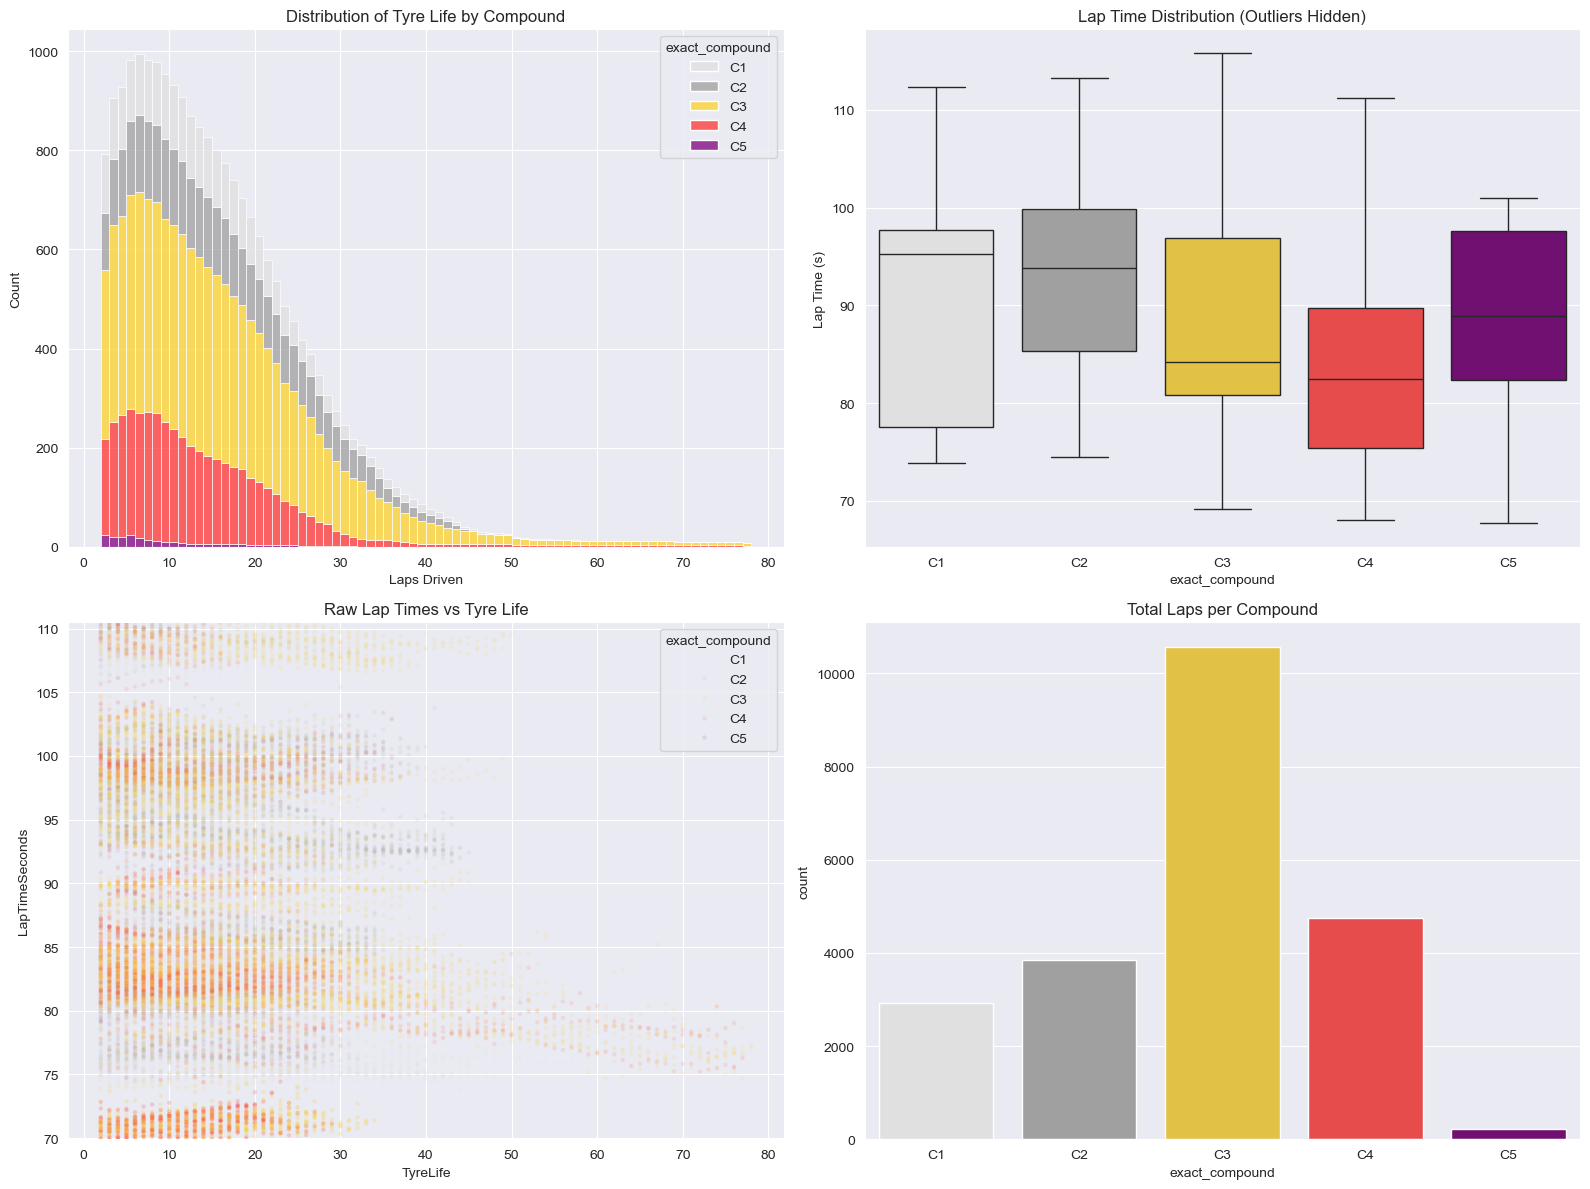

In [8]:
# %% [markdown]
# ### 1.2 Initial Data Quality Check

# %%
# 1. Count total laps by compound
print("📊 Total Laps by Compound:")
if 'exact_compound' in full_combined_data.columns:
    compound_counts = full_combined_data['exact_compound'].value_counts().sort_index()
    print(compound_counts)
else:
    print("⚠️ 'exact_compound' column missing. Using 'Compound' instead.")
    print(full_combined_data['Compound'].value_counts())

# 2. Identify missing values in key columns
print("\n🔍 Missing Values in Key Columns:")
key_cols = ['LapTimeSeconds', 'TyreLife', 'exact_compound', 'TrackTemp', 'AirTemp', 'dirty_air']
# Check if columns exist before checking nulls to avoid errors
existing_cols = [c for c in key_cols if c in full_combined_data.columns]
print(full_combined_data[existing_cols].isnull().sum())

# 3. Check for outliers in lap times
# We'll define outliers as laps > 107% of the median lap time (rough heuristic for safety cars/pit laps)
median_lap = full_combined_data['LapTimeSeconds'].median()
outlier_threshold = median_lap * 1.07
outliers = full_combined_data[full_combined_data['LapTimeSeconds'] > outlier_threshold]

print(f"\n⏱️ Lap Time Summary:")
print(f"   Median Lap Time: {median_lap:.3f}s")
print(f"   Outlier Threshold (>107%): {outlier_threshold:.3f}s")
print(f"   Potential Outliers (SC/VSC/In-laps): {len(outliers)} laps ({len(outliers)/len(full_combined_data)*100:.1f}%)")

# %% [markdown]
# ### 1.3 Visualization: Raw Data Overview

# %%
# Set up visualization style
sns.set_style("darkgrid")
plt.rcParams['figure.figsize'] = [14, 10]

# Define a consistent color palette for compounds C1-C5
# C1 (Hardest) -> C5 (Softest)
compound_colors = {
    'C1': '#E0E0E0', # Light Gray (Hard-ish)
    'C2': '#A0A0A0', # Gray
    'C3': '#FCD12A', # Yellow (Medium-ish)
    'C4': '#FF3333', # Red (Soft-ish)
    'C5': '#800080'  # Purple (Hyper Soft)
}
compound_order = ['C1', 'C2', 'C3', 'C4', 'C5']

# Filter data for plotting (remove NaNs in compound)
plot_df = full_combined_data.dropna(subset=['exact_compound']).copy()
# Ensure we only plot known compounds
plot_df = plot_df[plot_df['exact_compound'].isin(compound_order)]

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Histogram: Distribution of TyreLife
sns.histplot(data=plot_df, x='TyreLife', hue='exact_compound', 
             multiple='stack', palette=compound_colors, hue_order=compound_order, 
             binwidth=1, ax=axes[0, 0])
axes[0, 0].set_title('Distribution of Tyre Life by Compound')
axes[0, 0].set_xlabel('Laps Driven')

# 2. Box plot: Lap times by compound
sns.boxplot(data=plot_df, x='exact_compound', y='LapTimeSeconds', 
            palette=compound_colors, order=compound_order, ax=axes[0, 1], showfliers=False)
axes[0, 1].set_title('Lap Time Distribution (Outliers Hidden)')
axes[0, 1].set_ylabel('Lap Time (s)')

# 3. Scatter plot: Lap Time vs TyreLife
sns.scatterplot(data=plot_df, x='TyreLife', y='LapTimeSeconds', hue='exact_compound', 
                palette=compound_colors, hue_order=compound_order, 
                alpha=0.1, s=10, ax=axes[1, 0])
axes[1, 0].set_title('Raw Lap Times vs Tyre Life')
axes[1, 0].set_ylim(plot_df['LapTimeSeconds'].quantile(0.01), plot_df['LapTimeSeconds'].quantile(0.99)) # Zoom to bulk of data

# 4. Count plot just to see balance
sns.countplot(data=plot_df, x='exact_compound', palette=compound_colors, order=compound_order, ax=axes[1, 1])
axes[1, 1].set_title('Total Laps per Compound')

plt.tight_layout()

📏 Calculating Reliable Tire Life Ranges (min samples per bin: 20)...
   C1: up to 32 laps
   C2: up to 38 laps
   C3: up to 47 laps
   C4: up to 30 laps
   C5: up to 5 laps


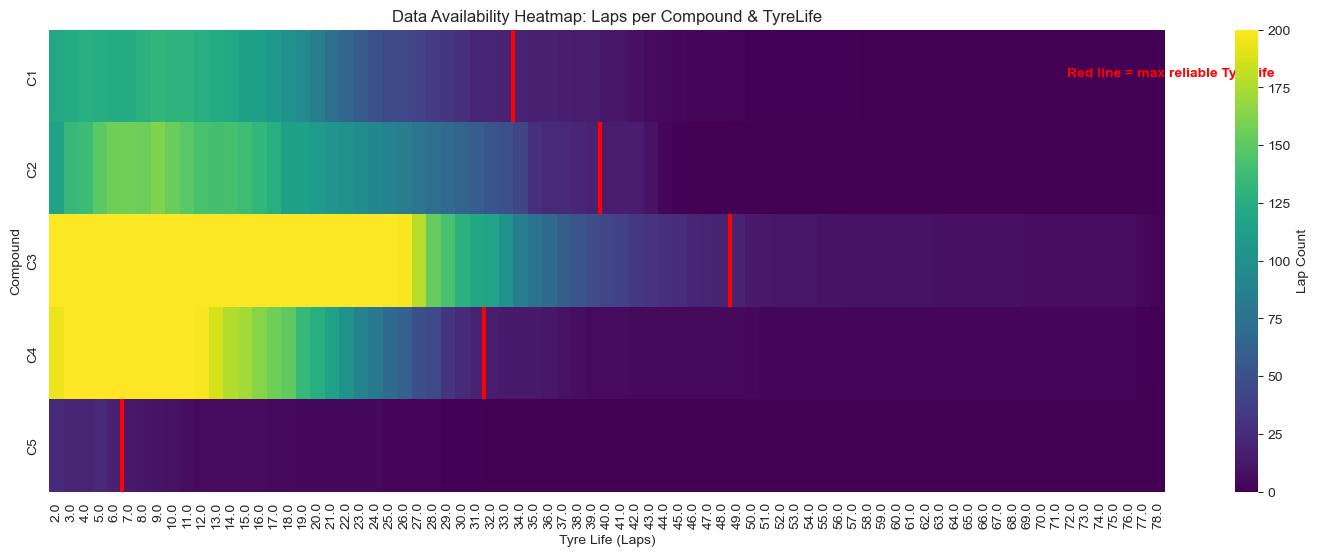


🧹 Filtering dataset to reliable ranges...


   Original laps: 23976
   Reliable laps: 21391
   Dropped laps: 2585 (10.8%)
   (Dropped = unknown compounds or TyreLife beyond reliable range)

   Max TyreLife retained per compound:
exact_compound
C1    32.0
C2    38.0
C3    47.0
C4    30.0
C5     5.0
Name: TyreLife, dtype: float64


In [9]:
# 2.1 Dynamic Reliable Data Ranges (computed from actual data)
min_samples = 20  # minimum laps required for a (compound, TyreLife) bin to be considered reliable
compound_order = ['C1', 'C2', 'C3', 'C4', 'C5']
reliable_ranges = {}

print(f"📏 Calculating Reliable Tire Life Ranges (min samples per bin: {min_samples})...")

if 'exact_compound' in full_combined_data.columns and 'TyreLife' in full_combined_data.columns:
    # Group to get lap counts per (compound, TyreLife)
    counts = (full_combined_data
              .groupby(['exact_compound', 'TyreLife'])
              .size()
              .rename('lap_count'))
    
    for comp in compound_order:
        if comp in counts.index.get_level_values(0):
            comp_counts = counts.loc[comp]
            valid_life = comp_counts[comp_counts >= min_samples].index
            reliable_ranges[comp] = int(valid_life.max()) if len(valid_life) else 0
        else:
            reliable_ranges[comp] = 0
else:
    print("⚠️ Required columns missing; falling back to defaults.")
    reliable_ranges = {'C1': 35, 'C2': 30, 'C3': 25, 'C4': 20, 'C5': 15}

for comp in compound_order:
    print(f"   {comp}: up to {reliable_ranges.get(comp, 0)} laps")

# 2.2 Visualization: Data Availability Heatmap
heatmap_df = full_combined_data.copy()
heatmap_df = heatmap_df[heatmap_df['exact_compound'].isin(compound_order)]

pivot_counts = (heatmap_df
                .pivot_table(index='exact_compound',
                             columns='TyreLife',
                             values='LapTimeSeconds',
                             aggfunc='count')
                .fillna(0)
                .reindex(compound_order))

plt.figure(figsize=(18, 6))
sns.heatmap(pivot_counts, cmap='viridis', vmax=200, cbar_kws={'label': 'Lap Count'})
plt.title('Data Availability Heatmap: Laps per Compound & TyreLife')
plt.xlabel('Tyre Life (Laps)')
plt.ylabel('Compound')

# Draw reliability boundary per compound
for y_idx, comp in enumerate(compound_order):
    limit = reliable_ranges.get(comp, 0)
    if limit > 0:
        plt.vlines(x=limit, ymin=y_idx, ymax=y_idx + 1, colors='red', linestyles='-', linewidth=3)
plt.text(x=pivot_counts.columns.max() * 0.9, y=0.5, s='Red line = max reliable TyreLife', color='red', fontweight='bold')
plt.show()

# 2.3 Filter dataset to reliable ranges (no extrapolation)
print("\n🧹 Filtering dataset to reliable ranges...")
if 'TyreLife' in full_combined_data.columns and 'exact_compound' in full_combined_data.columns:
    mask = full_combined_data['exact_compound'].isin(compound_order) & \
            full_combined_data.apply(lambda r: r['TyreLife'] <= reliable_ranges.get(r['exact_compound'], -1), axis=1)
    reliable_data = full_combined_data[mask].copy()
else:
    reliable_data = full_combined_data.copy()  # fallback

removed = len(full_combined_data) - len(reliable_data)
print(f"   Original laps: {len(full_combined_data)}")
print(f"   Reliable laps: {len(reliable_data)}")
print(f"   Dropped laps: {removed} ({removed / len(full_combined_data) * 100:.1f}%)")
print("   (Dropped = unknown compounds or TyreLife beyond reliable range)")

print("\n   Max TyreLife retained per compound:")
print(reliable_data.groupby('exact_compound')['TyreLife'].max().reindex(compound_order))

In [13]:
# %% [markdown]
# ## Section 3: Feature Engineering (Data-Driven Only)

# %%
def compute_fresh_baseline_and_target(df,
                                      lap_time_col='lap_time_fuel_corrected',
                                      tyre_life_col='TyreLife',
                                      group_cols=('Driver', 'EventName', 'Stint')):
    """
    Compute fresh baseline per stint (avg of laps with TyreLife 1-3) and
    target delta_from_fresh = lap_time_fuel_corrected - fresh_baseline.
    """
    d = df.copy()

    # Ensure required columns exist
    required = [lap_time_col, tyre_life_col] + list(group_cols)
    missing = [c for c in required if c not in d.columns]
    if missing:
        raise ValueError(f"Missing required columns: {missing}")

    # Fresh baseline: average of laps with TyreLife in [1..3] per stint
    fresh_mask = d[tyre_life_col].between(1, 3, inclusive='both')
    fresh_baseline = (d[fresh_mask]
                      .groupby(list(group_cols))[lap_time_col]
                      .mean()
                      .rename('fresh_baseline'))

    # Merge baseline back
    d = d.merge(fresh_baseline, on=list(group_cols), how='left')

    # If a stint lacks laps 1-3, fallback to min lap_time in stint as baseline
    fallback_baseline = (d.groupby(list(group_cols))[lap_time_col]
                         .min()
                         .rename('fallback_baseline'))
    d = d.merge(fallback_baseline, on=list(group_cols), how='left')
    d['fresh_baseline'] = d['fresh_baseline'].fillna(d['fallback_baseline'])
    d.drop(columns=['fallback_baseline'], inplace=True)

    # Target
    d['delta_from_fresh'] = d[lap_time_col] - d['fresh_baseline']
    return d


def build_feature_matrix(df):
    """
    Build data-driven feature matrix:
    - TyreLife
    - One-hot exact_compound (no ordinal ranking)
    - dirty_air
    - TrackTemp, AirTemp (if available)
    - Circuit characteristics (if available in dataset)
    """
    d = df.copy()

    # One-hot encode exact_compound
    if 'exact_compound' in d.columns:
        comp_dummies = pd.get_dummies(d['exact_compound'], prefix='compound')
        d = pd.concat([d, comp_dummies], axis=1)

    # Candidate feature columns (only keep those present)
    candidate_cols = [
        'TyreLife',
        'dirty_air',
        'TrackTemp',
        'AirTemp',
        # Circuit characteristics from circuit.csv
        'Traction',
        'Tyre Stress',
        'Asphalt Grip',
        'Asphalt Abrasion',
        'Track Evolution',
        'Breaking',
        'Lateral',
        'Downforce',
        'Lap Length'
    ]
    present_candidates = [c for c in candidate_cols if c in d.columns]

    # Include one-hot columns
    one_hot_cols = [c for c in d.columns if c.startswith('compound_')]

    feature_cols = present_candidates + one_hot_cols

    # Drop rows with missing core fields
    core_needed = ['delta_from_fresh', 'TyreLife']
    core_needed = [c for c in core_needed if c in d.columns]
    d = d.dropna(subset=core_needed)

    X = d[feature_cols].copy()
    y = d['delta_from_fresh'].copy()

    return X, y, feature_cols


# Run Section 3 on the reliable dataset from Section 2
print("🔧 Section 3: Computing data-driven target and features...")
if 'reliable_data' in globals() and not reliable_data.empty:
    engineered = compute_fresh_baseline_and_target(reliable_data)
    X, y, feature_cols = build_feature_matrix(engineered)
    print(f"✅ Features ready: {len(feature_cols)} columns")
    print(f"   Samples: X={len(X)}, y={len(y)}")
else:
    print("⚠️ reliable_data not found or empty. Run Section 2 first.")

🔧 Section 3: Computing data-driven target and features...
✅ Features ready: 18 columns
   Samples: X=21391, y=21391


In [14]:
# %% [markdown]
# ## Section 4: Train/Test Split Strategy (Stint-Based)

# %%
from sklearn.model_selection import train_test_split

# Ensure engineered dataset from Section 3 exists
if 'engineered' in globals() and not engineered.empty:
    df = engineered.copy()

    # Define stint_key = Driver + EventName + StintNumber/Stint
    # Try common stint column names, fallback to Stint if available
    stint_col = 'Stint' if 'Stint' in df.columns else ('StintNumber' if 'StintNumber' in df.columns else None)
    if stint_col is None:
        raise ValueError("No stint column found (expected 'Stint' or 'StintNumber').")

    df['stint_key'] = df['Driver'].astype(str) + '|' + df['EventName'].astype(str) + '|' + df[stint_col].astype(str)

    # Unique stints and optional stratification by main compound used in stint
    # Determine a representative compound per stint (mode)
    if 'exact_compound' in df.columns:
        comp_per_stint = (df.groupby('stint_key')['exact_compound']
                            .agg(lambda s: s.mode().iat[0] if not s.mode().empty else s.iloc[0]))
    else:
        comp_per_stint = pd.Series(index=df['stint_key'].unique(), dtype=object)
        comp_per_stint[:] = 'UNK'

    unique_stints = comp_per_stint.index.to_list()
    strat_labels = comp_per_stint.values

    # Split stints into train/test (80/20) using stint-level stratification by compound where possible
    try:
        stints_train, stints_test = train_test_split(unique_stints, test_size=0.2, random_state=42, stratify=strat_labels)
    except ValueError:
        # Fallback: no stratification if not enough samples per class
        stints_train, stints_test = train_test_split(unique_stints, test_size=0.2, random_state=42)

    # Build train/test dataframes by filtering laps belonging to selected stints
    train_mask = df['stint_key'].isin(stints_train)
    test_mask = df['stint_key'].isin(stints_test)

    train_df = df[train_mask].copy()
    test_df = df[test_mask].copy()

    print("✅ Stint-based split complete")
    print(f"   Train stints: {len(stints_train)} | Laps: {len(train_df)}")
    print(f"   Test stints:  {len(stints_test)} | Laps: {len(test_df)}")

    # Optional: quick compound balance check
    if 'exact_compound' in df.columns:
        print("\n📊 Compound distribution (stint-level mode):")
        print("Train:", pd.Series(comp_per_stint.loc[stints_train]).value_counts().to_dict())
        print("Test:", pd.Series(comp_per_stint.loc[stints_test]).value_counts().to_dict())

    # Prepare X/y for model training using previously built features
    X_train, y_train, feature_cols = build_feature_matrix(train_df)
    X_test, y_test, _ = build_feature_matrix(test_df)

else:
    print("⚠️ 'engineered' dataset not found. Run Section 3 first.")

✅ Stint-based split complete
   Train stints: 829 | Laps: 16997
   Test stints:  208 | Laps: 4394

📊 Compound distribution (stint-level mode):
Train: {'C3': 353, 'C4': 198, 'C2': 144, 'C1': 110, 'C5': 24}
Test: {'C3': 89, 'C4': 49, 'C2': 36, 'C1': 28, 'C5': 6}


In [15]:
# %% [markdown]
# ## Section 5: Model Training

# %%
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# Hyperparameters (Start Simple)
rf_params = {
    'n_estimators': 100,
    'max_depth': 10,
    'min_samples_leaf': 20,
    'random_state': 42,
    'n_jobs': -1
}

# 5.1/5.2/5.3 General Model: uses full feature matrix (including exact_compound one-hot)
if 'X_train' in globals() and 'y_train' in globals() and len(X_train) and len(y_train):
    general_model = RandomForestRegressor(**rf_params)
    general_model.fit(X_train, y_train)

    # Evaluate on test set if available
    if 'X_test' in globals() and 'y_test' in globals() and len(X_test) and len(y_test):
        y_pred = general_model.predict(X_test)
        r2 = r2_score(y_test, y_pred)
        rmse = mean_squared_error(y_test, y_pred, squared=False)
        mae = mean_absolute_error(y_test, y_pred)
        print("✅ General model trained")
        print(f"   R²:   {r2:.3f}")
        print(f"   RMSE: {rmse:.3f}s")
        print(f"   MAE:  {mae:.3f}s")
    else:
        print("⚠️ Test set not available; only trained the general model.")
else:
    print("❌ Training data not found. Ensure Section 4 created X_train/y_train.")

# 5.4 Per-Compound Models: train 5 separate models, one per exact_compound
per_compound_models = {}
compound_list = ['C1', 'C2', 'C3', 'C4', 'C5']

if 'train_df' in globals() and not train_df.empty and 'exact_compound' in train_df.columns:
    for comp in compound_list:
        comp_train = train_df[train_df['exact_compound'] == comp]
        if comp_train.empty:
            print(f"⚠️ No training data for {comp}; skipping model.")
            continue
        Xc, yc, feature_cols_c = build_feature_matrix(comp_train)
        if len(Xc) == 0:
            print(f"⚠️ No valid features for {comp}; skipping model.")
            continue
        model_c = RandomForestRegressor(**rf_params)
        model_c.fit(Xc, yc)
        per_compound_models[comp] = {
            'model': model_c,
            'features': feature_cols_c
        }
        print(f"✅ Trained per-compound model for {comp} | samples: {len(Xc)}")

    # Optional: evaluate each compound on its respective test subset
    if 'test_df' in globals() and not test_df.empty:
        for comp, entry in per_compound_models.items():
            comp_test = test_df[test_df['exact_compound'] == comp]
            if comp_test.empty:
                print(f"   ⚠️ No test data for {comp}; skipping evaluation.")
                continue
            Xtc, ytc, _ = build_feature_matrix(comp_test)
            if len(Xtc) == 0:
                print(f"   ⚠️ No valid test features for {comp}; skipping.")
                continue
            yhat = entry['model'].predict(Xtc)
            r2c = r2_score(ytc, yhat)
            rmsec = mean_squared_error(ytc, yhat, squared=False)
            maec = mean_absolute_error(ytc, yhat)
            print(f"   📊 {comp} | R²={r2c:.3f} RMSE={rmsec:.3f}s MAE={maec:.3f}s")
else:
    print("❌ Per-compound training data not available or missing 'exact_compound'.")

✅ General model trained
   R²:   0.283
   RMSE: 1.093s
   MAE:  0.635s
✅ Trained per-compound model for C1 | samples: 2112
✅ Trained per-compound model for C2 | samples: 3108
✅ Trained per-compound model for C2 | samples: 3108
✅ Trained per-compound model for C3 | samples: 8150
✅ Trained per-compound model for C4 | samples: 3558
✅ Trained per-compound model for C3 | samples: 8150
✅ Trained per-compound model for C4 | samples: 3558
✅ Trained per-compound model for C5 | samples: 69
   📊 C1 | R²=0.097 RMSE=0.853s MAE=0.625s
   📊 C2 | R²=-0.051 RMSE=1.245s MAE=0.748s
   📊 C3 | R²=0.355 RMSE=0.880s MAE=0.604s
   📊 C4 | R²=0.670 RMSE=1.046s MAE=0.585s
   📊 C5 | R²=-0.069 RMSE=0.611s MAE=0.506s
✅ Trained per-compound model for C5 | samples: 69
   📊 C1 | R²=0.097 RMSE=0.853s MAE=0.625s
   📊 C2 | R²=-0.051 RMSE=1.245s MAE=0.748s
   📊 C3 | R²=0.355 RMSE=0.880s MAE=0.604s
   📊 C4 | R²=0.670 RMSE=1.046s MAE=0.585s
   📊 C5 | R²=-0.069 RMSE=0.611s MAE=0.506s


✅ General Model Validation
   R²:   0.283
   RMSE: 1.093s
   MAE:  0.635s
✅ C1 Model Validation
   R²:   0.097
   RMSE: 0.853s
   MAE:  0.625s
✅ C2 Model Validation
   R²:   -0.051
   RMSE: 1.245s
   MAE:  0.748s
✅ C3 Model Validation
   R²:   0.355
   RMSE: 0.880s
   MAE:  0.604s
✅ C4 Model Validation
   R²:   0.670
   RMSE: 1.046s
   MAE:  0.585s
✅ C5 Model Validation
   R²:   -0.069
   RMSE: 0.611s
   MAE:  0.506s

🔎 Predicted vs Actual by TyreLife checkpoints (general model):
   C1 TL=5: actual mean=0.223s | pred mean=0.265s | n=28
   C1 TL=10: actual mean=0.668s | pred mean=0.745s | n=28
   C1 TL=15: actual mean=0.849s | pred mean=1.099s | n=26
   C2 TL=5: actual mean=-0.078s | pred mean=-0.656s | n=27
   C2 TL=10: actual mean=0.350s | pred mean=-0.086s | n=30
   C2 TL=15: actual mean=0.358s | pred mean=-0.060s | n=23
   C3 TL=5: actual mean=-0.122s | pred mean=-0.044s | n=90
   C3 TL=10: actual mean=0.217s | pred mean=0.241s | n=85
   C3 TL=15: actual mean=0.580s | pred mean=0.64

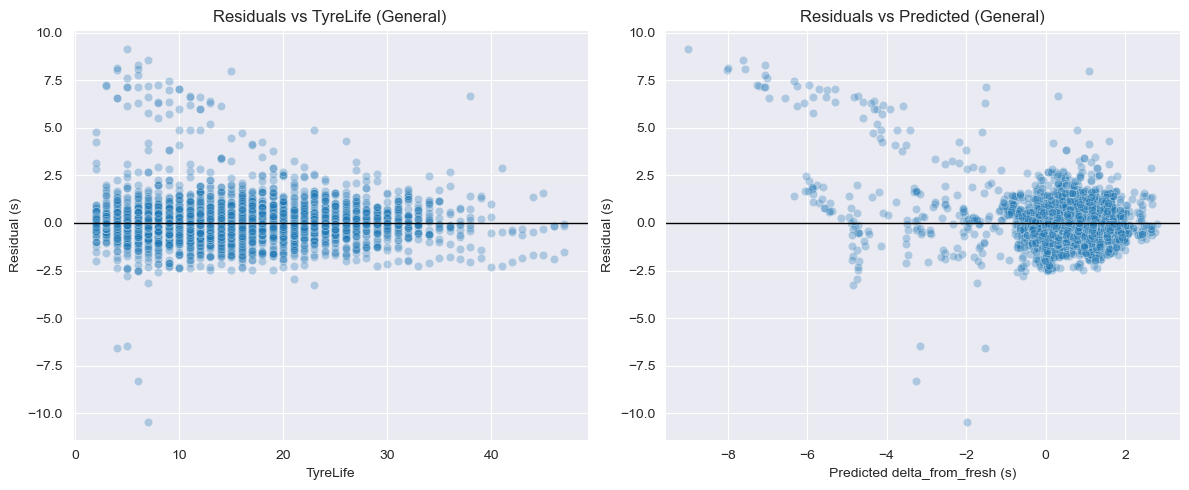

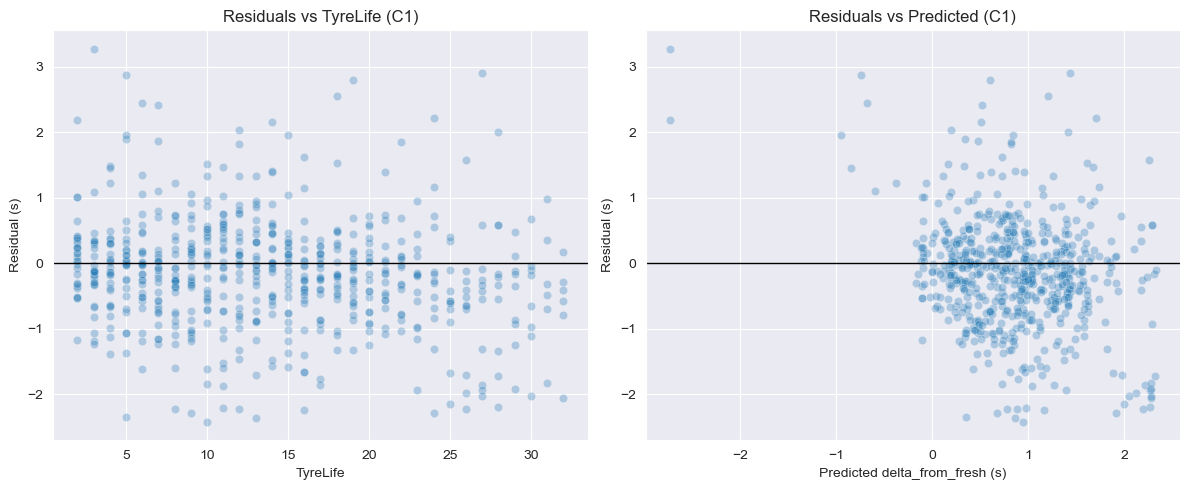

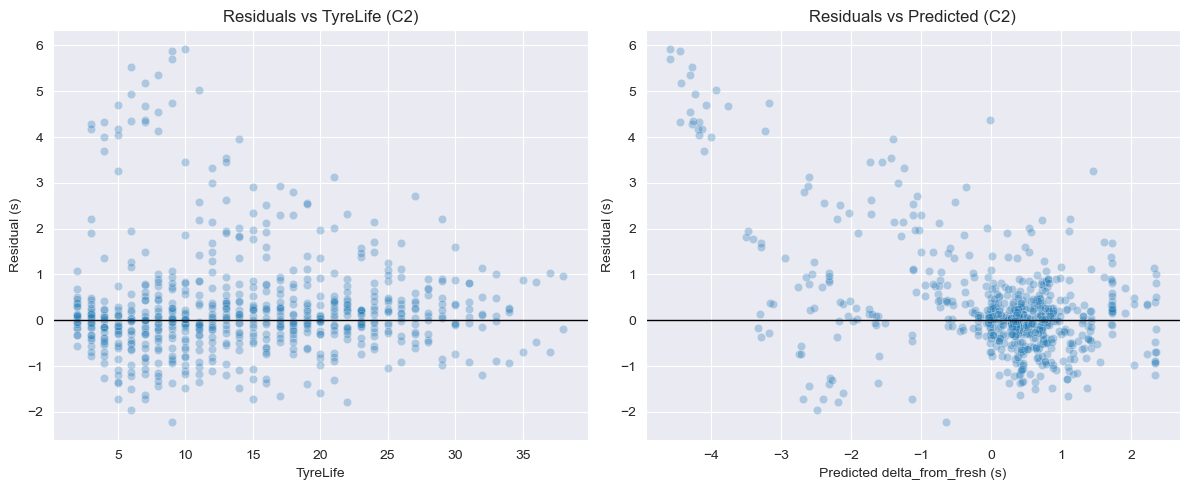

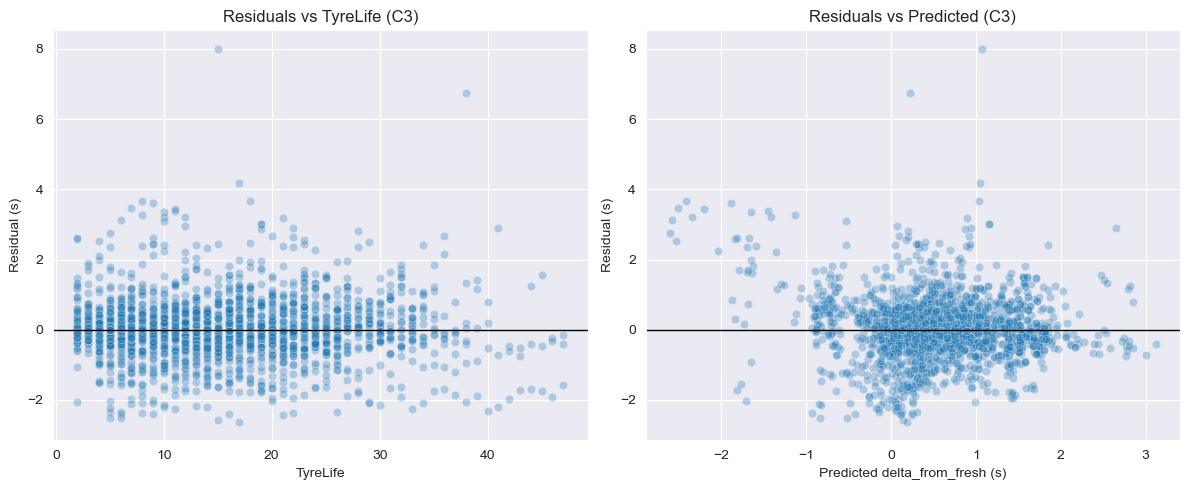

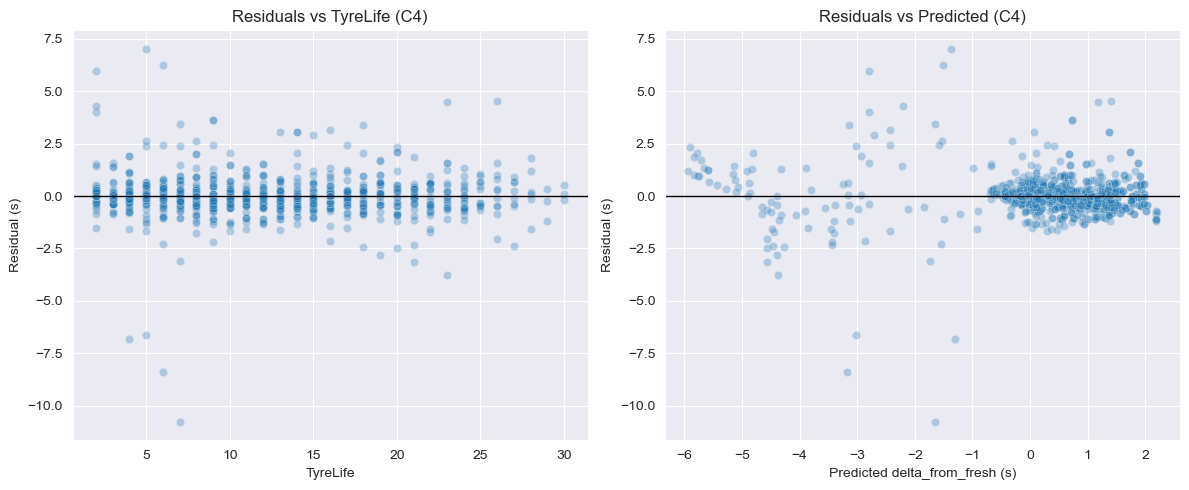

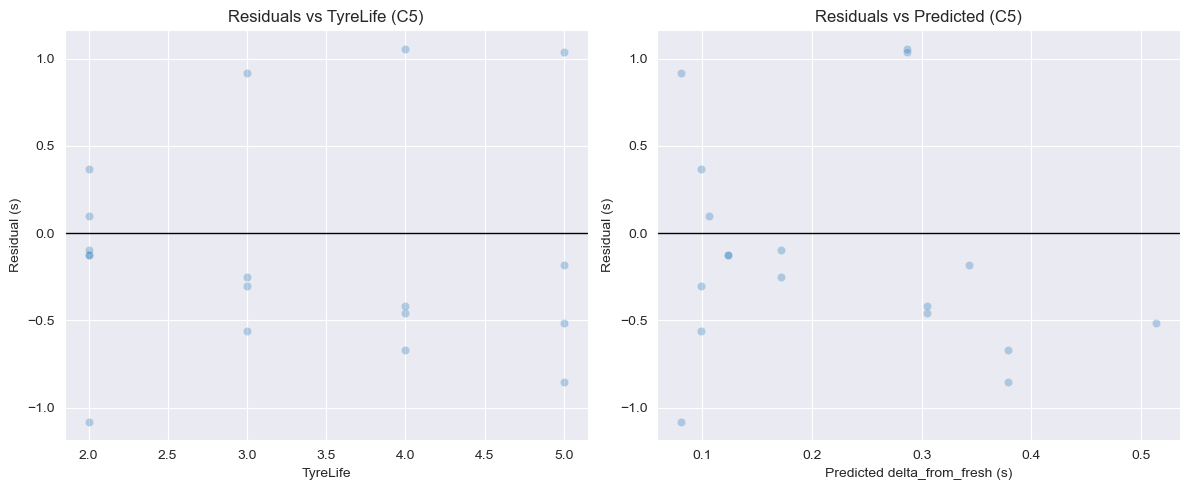

In [19]:
# %% [markdown]
# ## Section 6: Model Validation

# %%
import numpy as np
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

def align_features(X_df, expected_cols):
    """
    Ensure X_df has exactly expected_cols in the same order.
    Add missing columns filled with 0 and drop unexpected ones.
    """
    X = X_df.copy()
    # Add missing columns
    missing = [c for c in expected_cols if c not in X.columns]
    for c in missing:
        X[c] = 0.0
    # Drop unexpected columns
    extra = [c for c in X.columns if c not in expected_cols]
    if extra:
        X = X.drop(columns=extra)
    # Order columns
    return X[expected_cols]

# Validate General Model
if 'general_model' in globals() and 'X_test' in globals() and 'y_test' in globals() and len(X_test):
    # Ensure X_test matches feature_cols used at fit time
    X_test_aligned = align_features(X_test, feature_cols) if 'feature_cols' in globals() else X_test
    y_pred_gen = general_model.predict(X_test_aligned)
    r2_gen = r2_score(y_test, y_pred_gen)
    rmse_gen = mean_squared_error(y_test, y_pred_gen, squared=False)
    mae_gen = mean_absolute_error(y_test, y_pred_gen)
    print("✅ General Model Validation")
    print(f"   R²:   {r2_gen:.3f}")
    print(f"   RMSE: {rmse_gen:.3f}s")
    print(f"   MAE:  {mae_gen:.3f}s")
else:
    print("⚠️ General model or test set missing; skip general validation.")

# Validate Per-Compound Models
if 'per_compound_models' in globals() and isinstance(per_compound_models, dict) and 'test_df' in globals() and not test_df.empty:
    for comp, entry in per_compound_models.items():
        comp_test_df = test_df[test_df['exact_compound'] == comp]
        if comp_test_df.empty:
            print(f"⚠️ No test laps for {comp}; skipping.")
            continue
        Xc_test, yc_test, _ = build_feature_matrix(comp_test_df)
        if len(Xc_test) == 0:
            print(f"⚠️ No valid features for {comp} test; skipping.")
            continue
        # Align features to this compound model's training features
        model_feature_cols = entry.get('features', Xc_test.columns.tolist())
        Xc_test_aligned = align_features(Xc_test, model_feature_cols)
        yhat_c = entry['model'].predict(Xc_test_aligned)
        r2_c = r2_score(yc_test, yhat_c)
        rmse_c = mean_squared_error(yc_test, yhat_c, squared=False)
        mae_c = mean_absolute_error(yc_test, yhat_c)
        print(f"✅ {comp} Model Validation")
        print(f"   R²:   {r2_c:.3f}")
        print(f"   RMSE: {rmse_c:.3f}s")
        print(f"   MAE:  {mae_c:.3f}s")
else:
    print("⚠️ Per-compound models or test_df missing; skip compound validation.")

# Per-compound predicted vs actual at TyreLife 5, 10, 15 (general model)
if 'general_model' in globals() and 'test_df' in globals() and not test_df.empty:
    checkpoints = [5, 10, 15]
    compounds = ['C1', 'C2', 'C3', 'C4', 'C5']
    print("\n🔎 Predicted vs Actual by TyreLife checkpoints (general model):")
    for comp in compounds:
        comp_df = test_df[(test_df['exact_compound'] == comp) & (test_df['TyreLife'].isin(checkpoints))].copy()
        if comp_df.empty:
            print(f"   ⚠️ No test laps at checkpoints for {comp}")
            continue
        Xc, yc, _ = build_feature_matrix(comp_df)
        if len(Xc) == 0:
            print(f"   ⚠️ No features at checkpoints for {comp}")
            continue
        # Align to general model's training features
        Xc_aligned = align_features(Xc, feature_cols) if 'feature_cols' in globals() else Xc
        yhat = general_model.predict(Xc_aligned)
        comp_df = comp_df.assign(pred=yhat, actual=yc)
        for t in checkpoints:
            row_t = comp_df[comp_df['TyreLife'] == t]
            if row_t.empty:
                continue
            print(f"   {comp} TL={t}: actual mean={row_t['actual'].mean():.3f}s | pred mean={row_t['pred'].mean():.3f}s | n={len(row_t)}")

# Residual plots (general model)
if 'y_pred_gen' in globals() or ('general_model' in globals() and 'X_test' in globals() and len(X_test)):
    import matplotlib.pyplot as plt
    import seaborn as sns
    # Ensure predictions for residuals
    if 'y_pred_gen' not in globals():
        X_test_aligned = align_features(X_test, feature_cols) if 'feature_cols' in globals() else X_test
        y_pred_gen = general_model.predict(X_test_aligned)
    resid = y_test - y_pred_gen
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    tl_axis = X_test['TyreLife'] if 'TyreLife' in X_test.columns else np.arange(len(resid))
    sns.scatterplot(x=tl_axis, y=resid, alpha=0.3)
    plt.axhline(0, color='black', linewidth=1)
    plt.title('Residuals vs TyreLife (General)')
    plt.xlabel('TyreLife')
    plt.ylabel('Residual (s)')

    plt.subplot(1,2,2)
    sns.scatterplot(x=y_pred_gen, y=resid, alpha=0.3)
    plt.axhline(0, color='black', linewidth=1)
    plt.title('Residuals vs Predicted (General)')
    plt.xlabel('Predicted delta_from_fresh (s)')
    plt.ylabel('Residual (s)')
    plt.tight_layout()
    plt.show()

# Residual plots per compound
if 'per_compound_models' in globals() and isinstance(per_compound_models, dict) and 'test_df' in globals() and not test_df.empty:
    for comp, entry in per_compound_models.items():
        comp_test_df = test_df[test_df['exact_compound'] == comp]
        if comp_test_df.empty:
            continue
        Xc_test, yc_test, _ = build_feature_matrix(comp_test_df)
        if len(Xc_test) == 0:
            continue
        model_feature_cols = entry.get('features', Xc_test.columns.tolist())
        Xc_test_aligned = align_features(Xc_test, model_feature_cols)
        yhat_c = entry['model'].predict(Xc_test_aligned)
        resid_c = yc_test - yhat_c
        import matplotlib.pyplot as plt
        import seaborn as sns
        plt.figure(figsize=(12,5))
        plt.subplot(1,2,1)
        tl = Xc_test_aligned['TyreLife'] if 'TyreLife' in Xc_test_aligned.columns else np.arange(len(resid_c))
        sns.scatterplot(x=tl, y=resid_c, alpha=0.3)
        plt.axhline(0, color='black', linewidth=1)
        plt.title(f'Residuals vs TyreLife ({comp})')
        plt.xlabel('TyreLife')
        plt.ylabel('Residual (s)')

        plt.subplot(1,2,2)
        sns.scatterplot(x=yhat_c, y=resid_c, alpha=0.3)
        plt.axhline(0, color='black', linewidth=1)
        plt.title(f'Residuals vs Predicted ({comp})')
        plt.xlabel('Predicted delta_from_fresh (s)')
        plt.ylabel('Residual (s)')
        plt.tight_layout()
        plt.show()

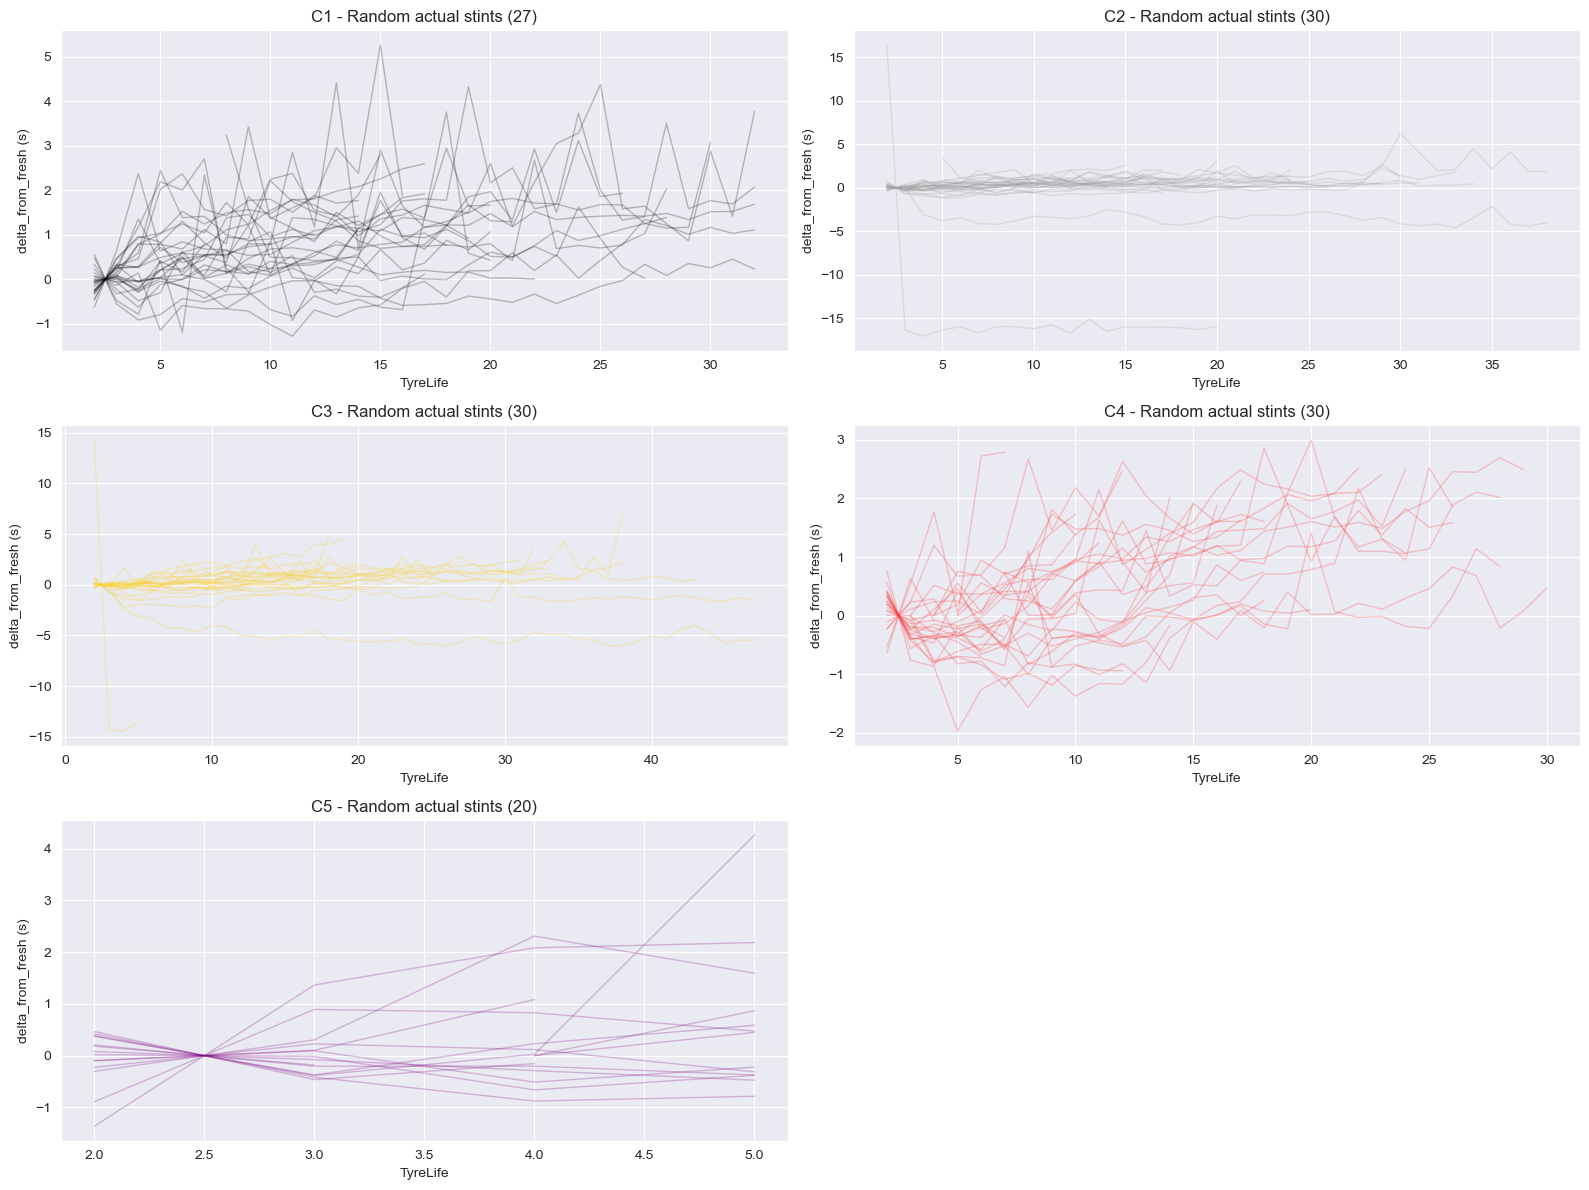

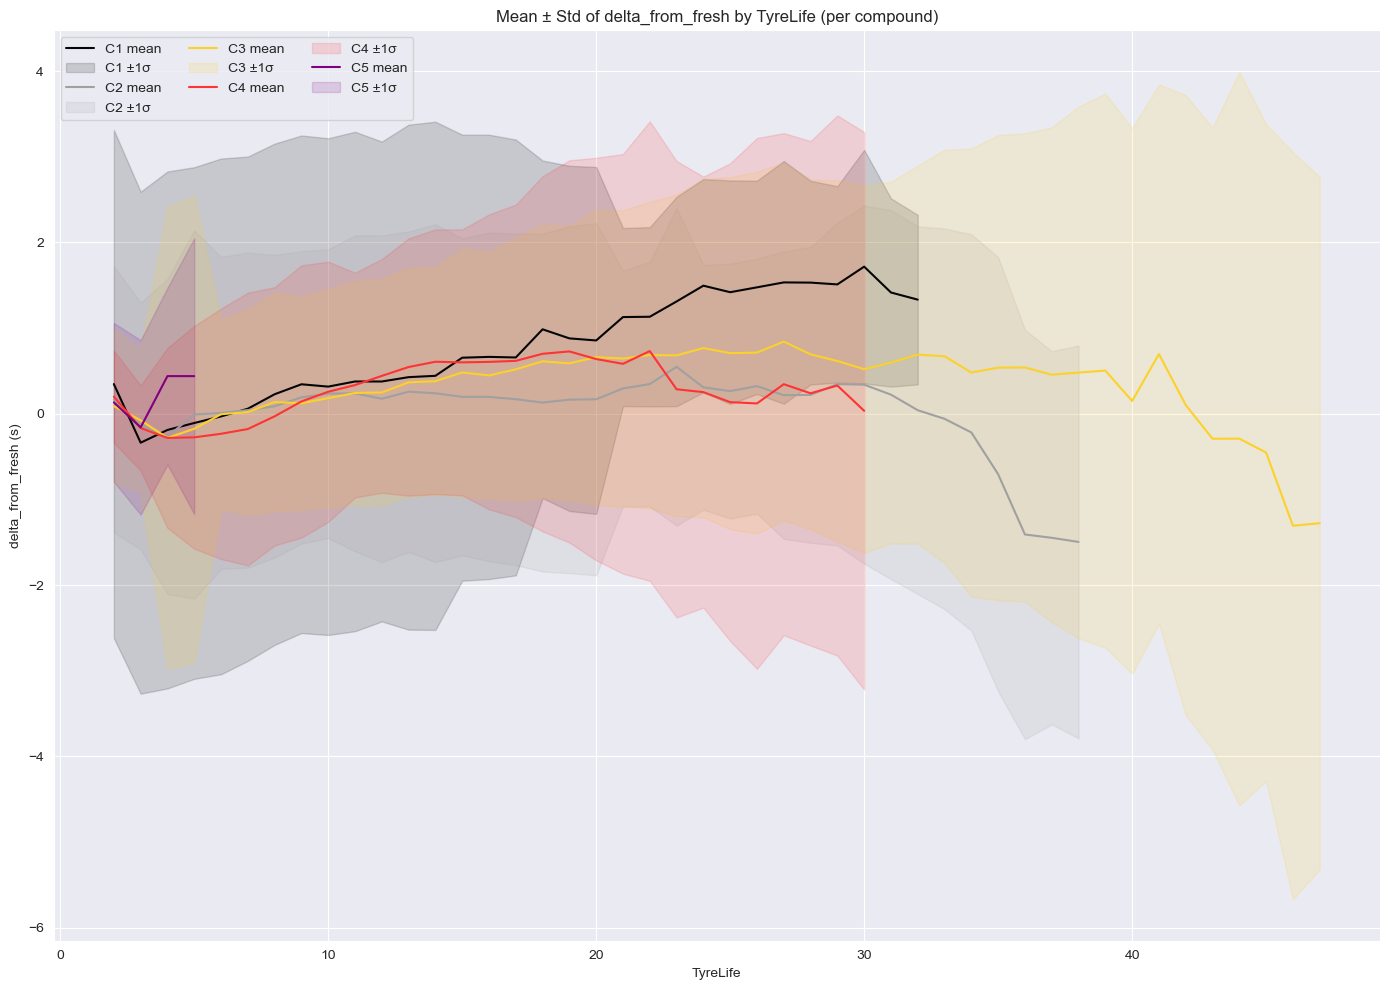

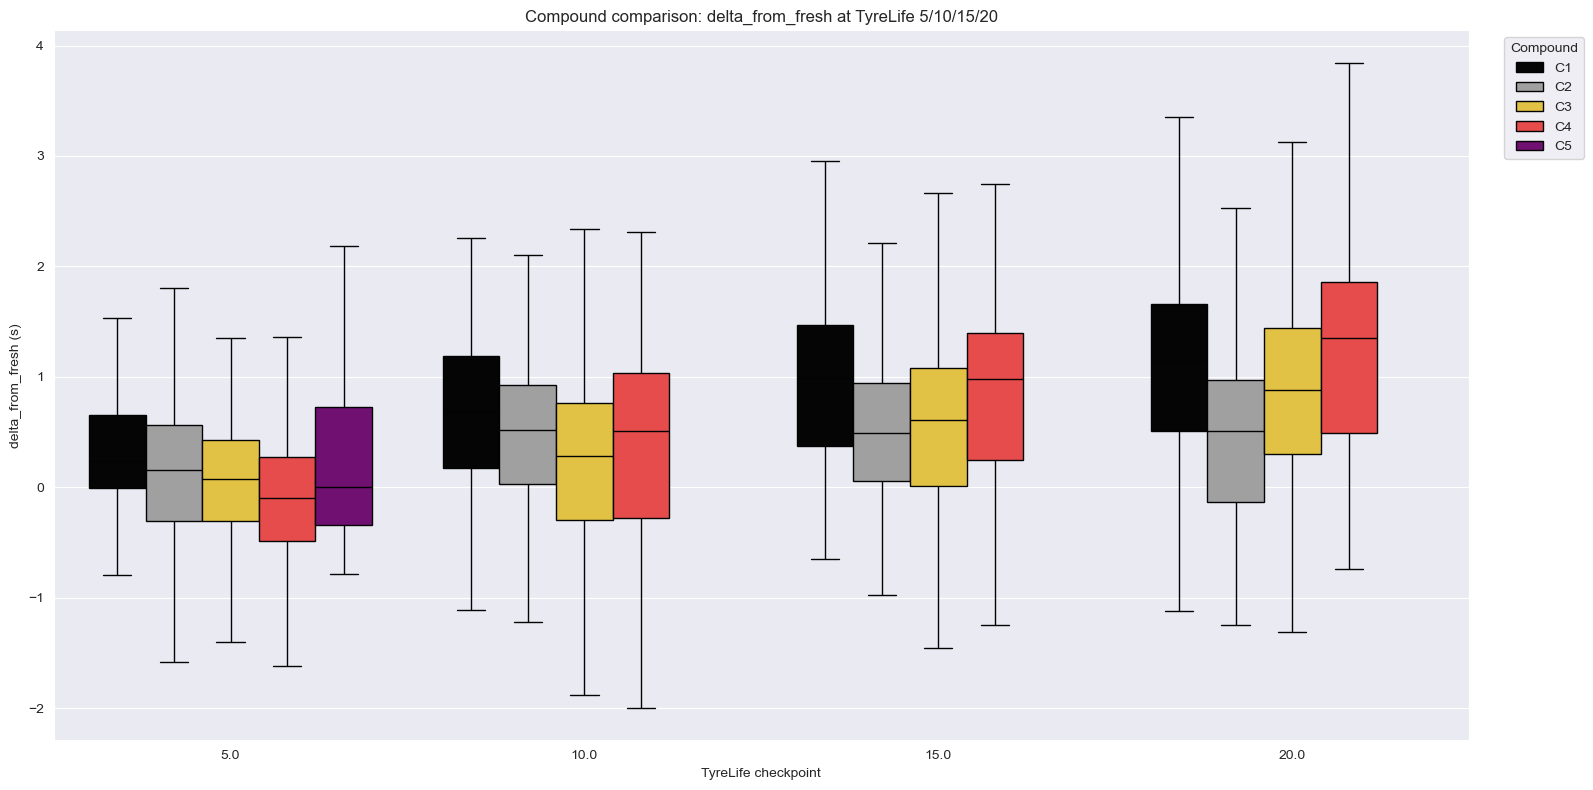

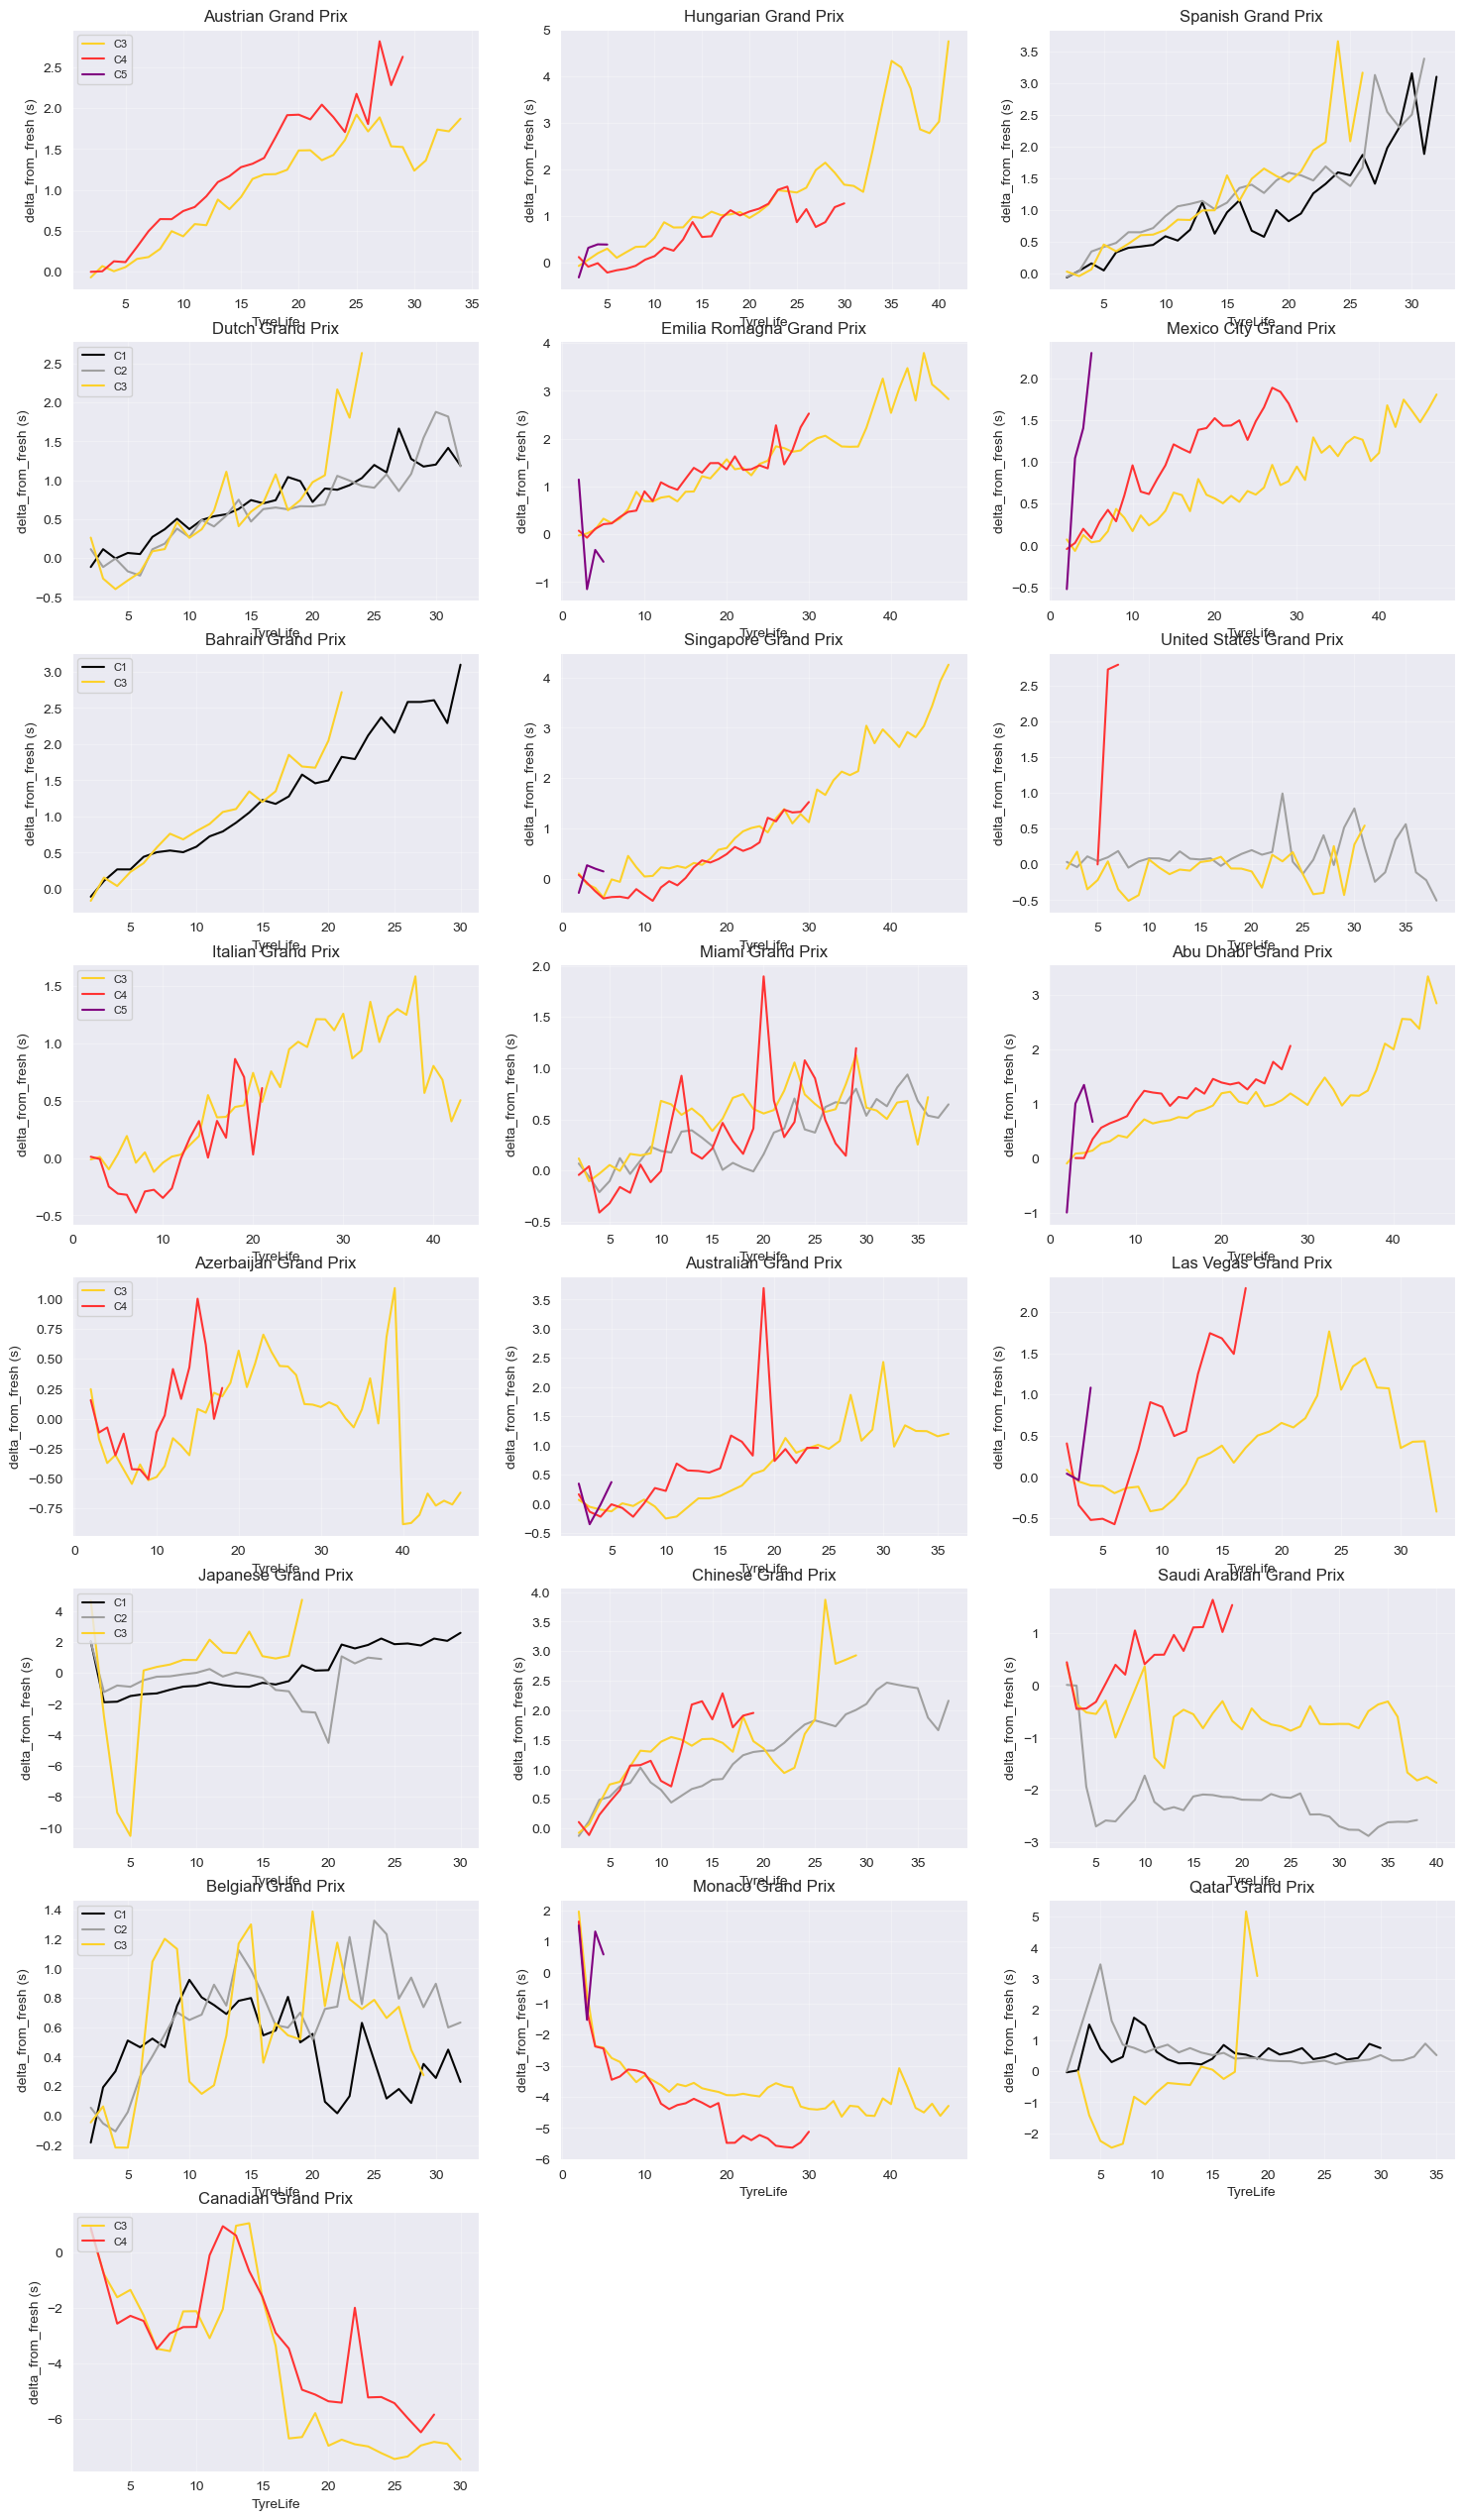

In [21]:
# %% [markdown]
# ## Section 7: Visualizations - Raw Data

# %%
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("darkgrid")

# Ensure we have the engineered dataset with delta_from_fresh
if 'engineered' not in globals() or engineered.empty:
    raise RuntimeError("Section 7 requires 'engineered' from Section 3. Run Sections 2-3 first.")

# Use known compound order and colors
compound_order = ['C1', 'C2', 'C3', 'C4', 'C5']
compound_colors = {
    'C1': "#050505",
    'C2': '#A0A0A0',
    'C3': '#FCD12A',
    'C4': '#FF3333',
    'C5': '#800080'
}

plot_df = engineered.dropna(subset=['exact_compound', 'TyreLife', 'delta_from_fresh']).copy()
plot_df = plot_df[plot_df['exact_compound'].isin(compound_order)]

# Helper for palette mapping
def color_for(comp):
    return compound_colors.get(comp, '#555555')

# 7.1 Actual Stint Degradation Curves (20-30 random stints per compound)
plt.figure(figsize=(16, 12))
for idx, comp in enumerate(compound_order, start=1):
    ax = plt.subplot(3, 2, idx)
    comp_df = plot_df[plot_df['exact_compound'] == comp]
    if comp_df.empty:
        ax.set_title(f"{comp}: no data")
        continue
    # Define stint_key
    stint_col = 'Stint' if 'Stint' in comp_df.columns else ('StintNumber' if 'StintNumber' in comp_df.columns else None)
    comp_df['stint_key'] = comp_df['Driver'].astype(str) + '|' + comp_df['EventName'].astype(str) + '|' + comp_df[stint_col].astype(str) if stint_col else comp_df['Driver'].astype(str) + '|' + comp_df['EventName'].astype(str)
    unique_stints = comp_df['stint_key'].unique()
    n_to_plot = min(30, max(20, int(len(unique_stints) * 0.2)))  # aim 20-30
    sampled = np.random.default_rng(42).choice(unique_stints, size=min(n_to_plot, len(unique_stints)), replace=False)
    for sk in sampled:
        s = comp_df[comp_df['stint_key'] == sk].sort_values('TyreLife')
        ax.plot(s['TyreLife'], s['delta_from_fresh'], color=color_for(comp), alpha=0.25, linewidth=1)
    ax.set_title(f"{comp} - Random actual stints ({len(sampled)})")
    ax.set_xlabel('TyreLife')
    ax.set_ylabel('delta_from_fresh (s)')
plt.tight_layout()
plt.show()

# 7.2 Mean ± Standard Deviation by TyreLife per compound
plt.figure(figsize=(14, 10))
for comp in compound_order:
    comp_df = plot_df[plot_df['exact_compound'] == comp]
    if comp_df.empty:
        continue
    agg = comp_df.groupby('TyreLife')['delta_from_fresh'].agg(['mean', 'std', 'count']).reset_index()
    c = color_for(comp)
    plt.plot(agg['TyreLife'], agg['mean'], label=f"{comp} mean", color=c)
    # Shade mean ± std (only where count >= 5 to avoid noisy bands)
    mask = agg['count'] >= 5
    plt.fill_between(agg['TyreLife'][mask], (agg['mean'] - agg['std'])[mask], (agg['mean'] + agg['std'])[mask], color=c, alpha=0.15, label=f"{comp} ±1σ")
plt.title('Mean ± Std of delta_from_fresh by TyreLife (per compound)')
plt.xlabel('TyreLife')
plt.ylabel('delta_from_fresh (s)')
plt.legend(ncol=3)
plt.tight_layout()
plt.show()

# 7.3 Compound Comparison (Raw Data) at TyreLife checkpoints
checkpoints = [5, 10, 15, 20]
cp_df = plot_df[plot_df['TyreLife'].isin(checkpoints)].copy()
if cp_df.empty:
    print("⚠️ No data at TyreLife checkpoints (5,10,15,20).")
else:
    # To keep order and colors consistent, use categorical ordering
    cp_df['exact_compound'] = pd.Categorical(cp_df['exact_compound'], categories=compound_order, ordered=True)
    plt.figure(figsize=(16, 8))
    sns.boxplot(
        data=cp_df,
        x='TyreLife',
        y='delta_from_fresh',
        hue='exact_compound',
        palette=[compound_colors[c] for c in compound_order],
        showfliers=False
    )
    plt.title('Compound comparison: delta_from_fresh at TyreLife 5/10/15/20')
    plt.xlabel('TyreLife checkpoint')
    plt.ylabel('delta_from_fresh (s)')
    plt.legend(title='Compound', bbox_to_anchor=(1.02, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

# 7.4 Circuit Effects: faceted degradation curves by EventName
# Limit to circuits with sufficient data to keep plot readable
min_laps_per_event = 300  # adjust if needed
events = plot_df['EventName'].value_counts()
selected_events = events[events >= min_laps_per_event].index.tolist()
facet_df = plot_df[plot_df['EventName'].isin(selected_events)].copy()

if facet_df.empty:
    print("⚠️ Not enough laps per event for faceted circuit plots. Lower min_laps_per_event if needed.")
else:
    # Create per-event TyreLife mean by compound to reduce clutter
    facet_agg = (facet_df
                 .groupby(['EventName', 'exact_compound', 'TyreLife'])['delta_from_fresh']
                 .mean()
                 .reset_index())

    # Build facets
    n_events = len(selected_events)
    cols = 3
    rows = int(np.ceil(n_events / cols))
    plt.figure(figsize=(6 * cols, 4 * rows))
    for i, event in enumerate(selected_events, start=1):
        ax = plt.subplot(rows, cols, i)
        ev = facet_agg[facet_agg['EventName'] == event]
        for comp in compound_order:
            evc = ev[ev['exact_compound'] == comp]
            if evc.empty:
                continue
            ax.plot(evc['TyreLife'], evc['delta_from_fresh'], label=comp, color=color_for(comp))
        ax.set_title(event)
        ax.set_xlabel('TyreLife')
        ax.set_ylabel('delta_from_fresh (s)')
        ax.grid(True, alpha=0.3)
        if i % cols == 1:
            ax.legend(loc='upper left', fontsize=8)

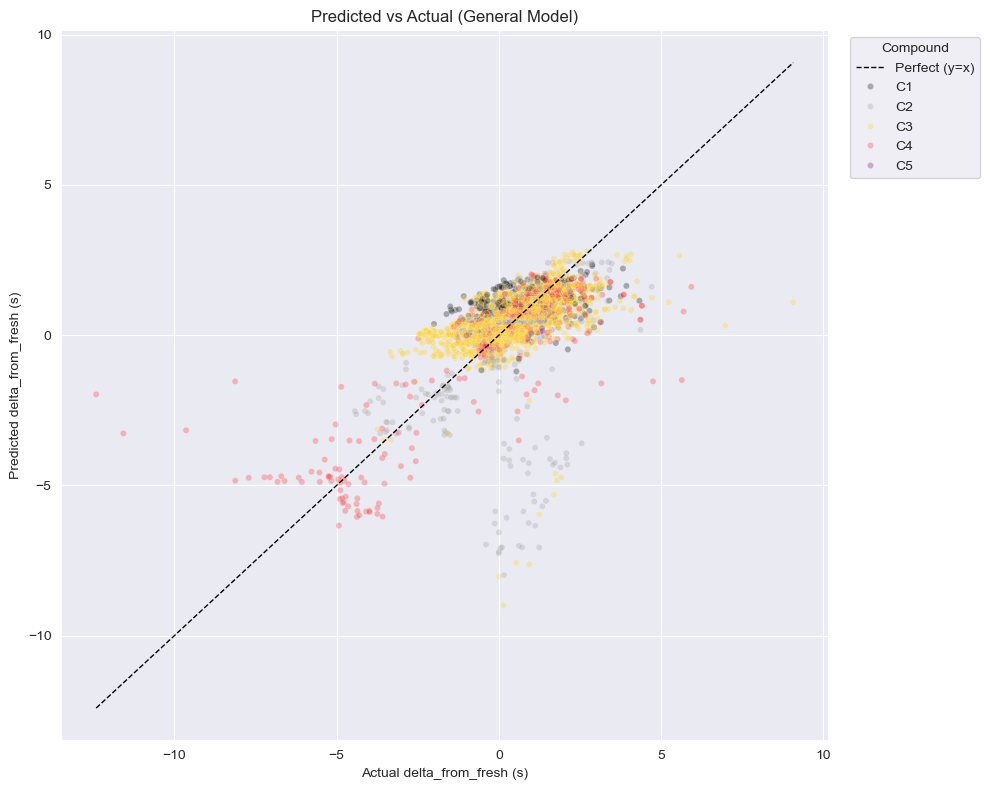

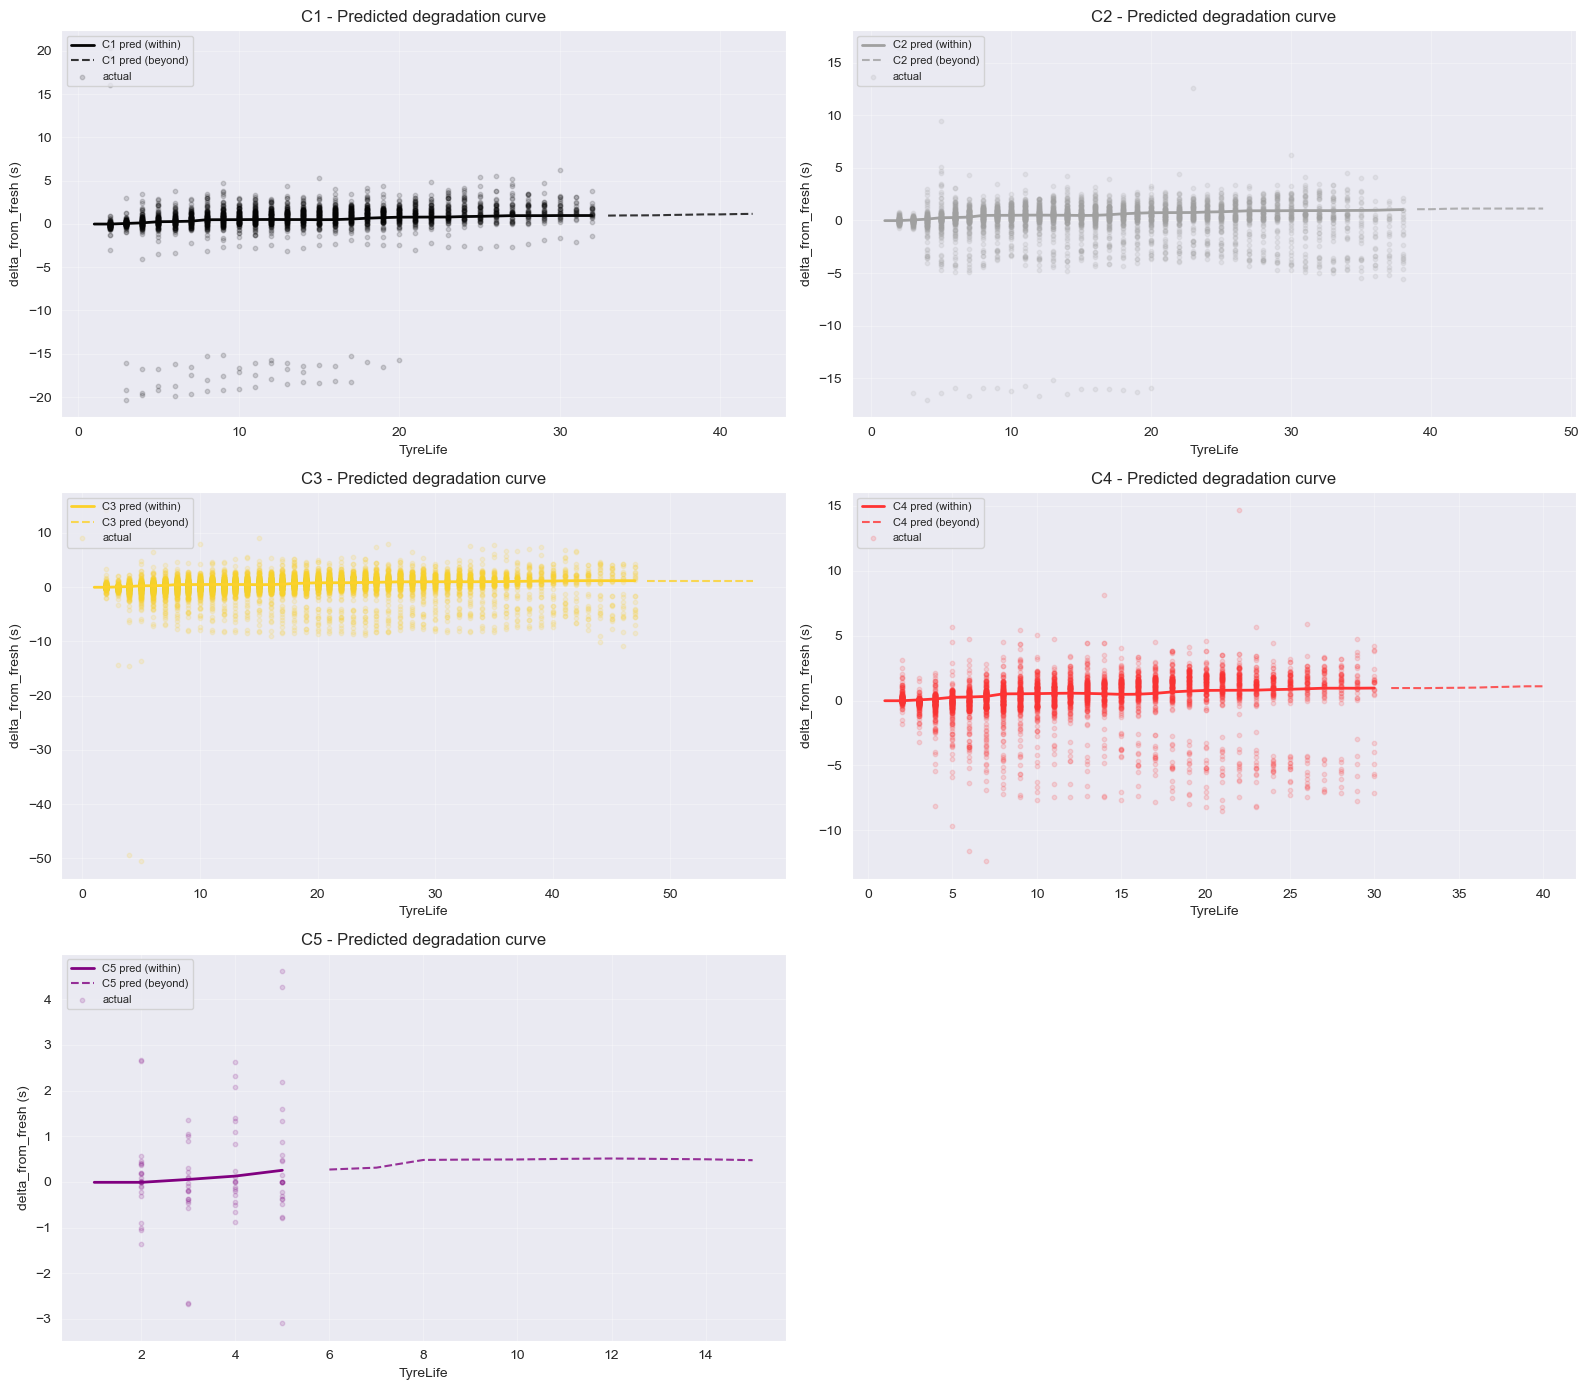

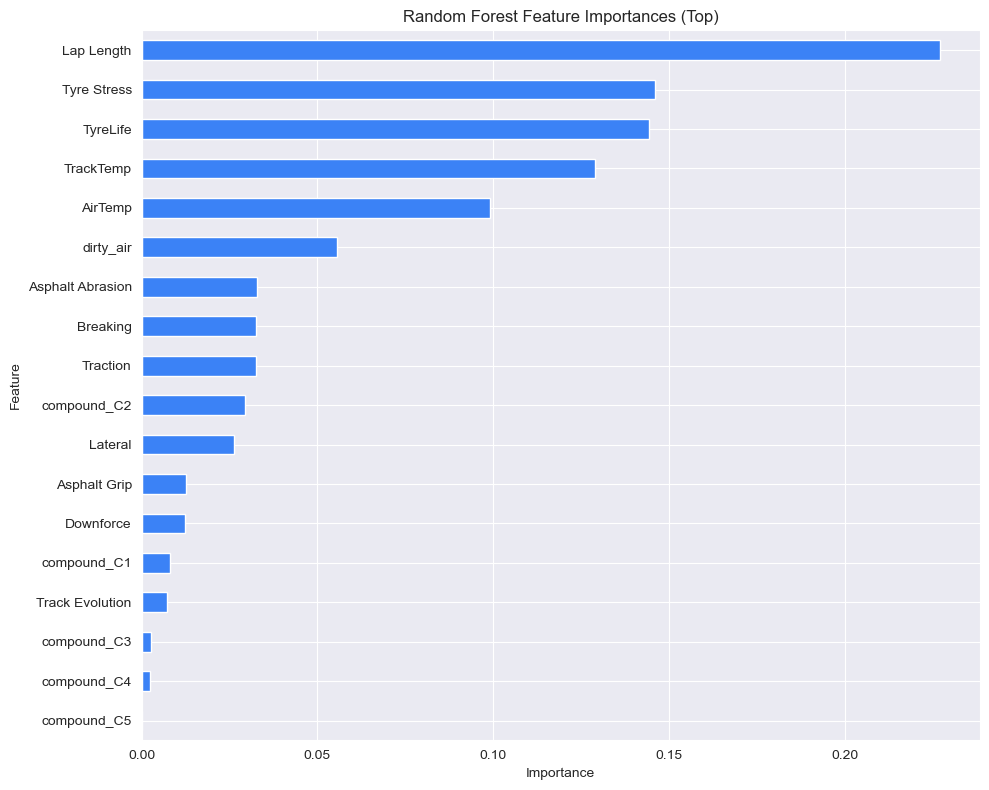

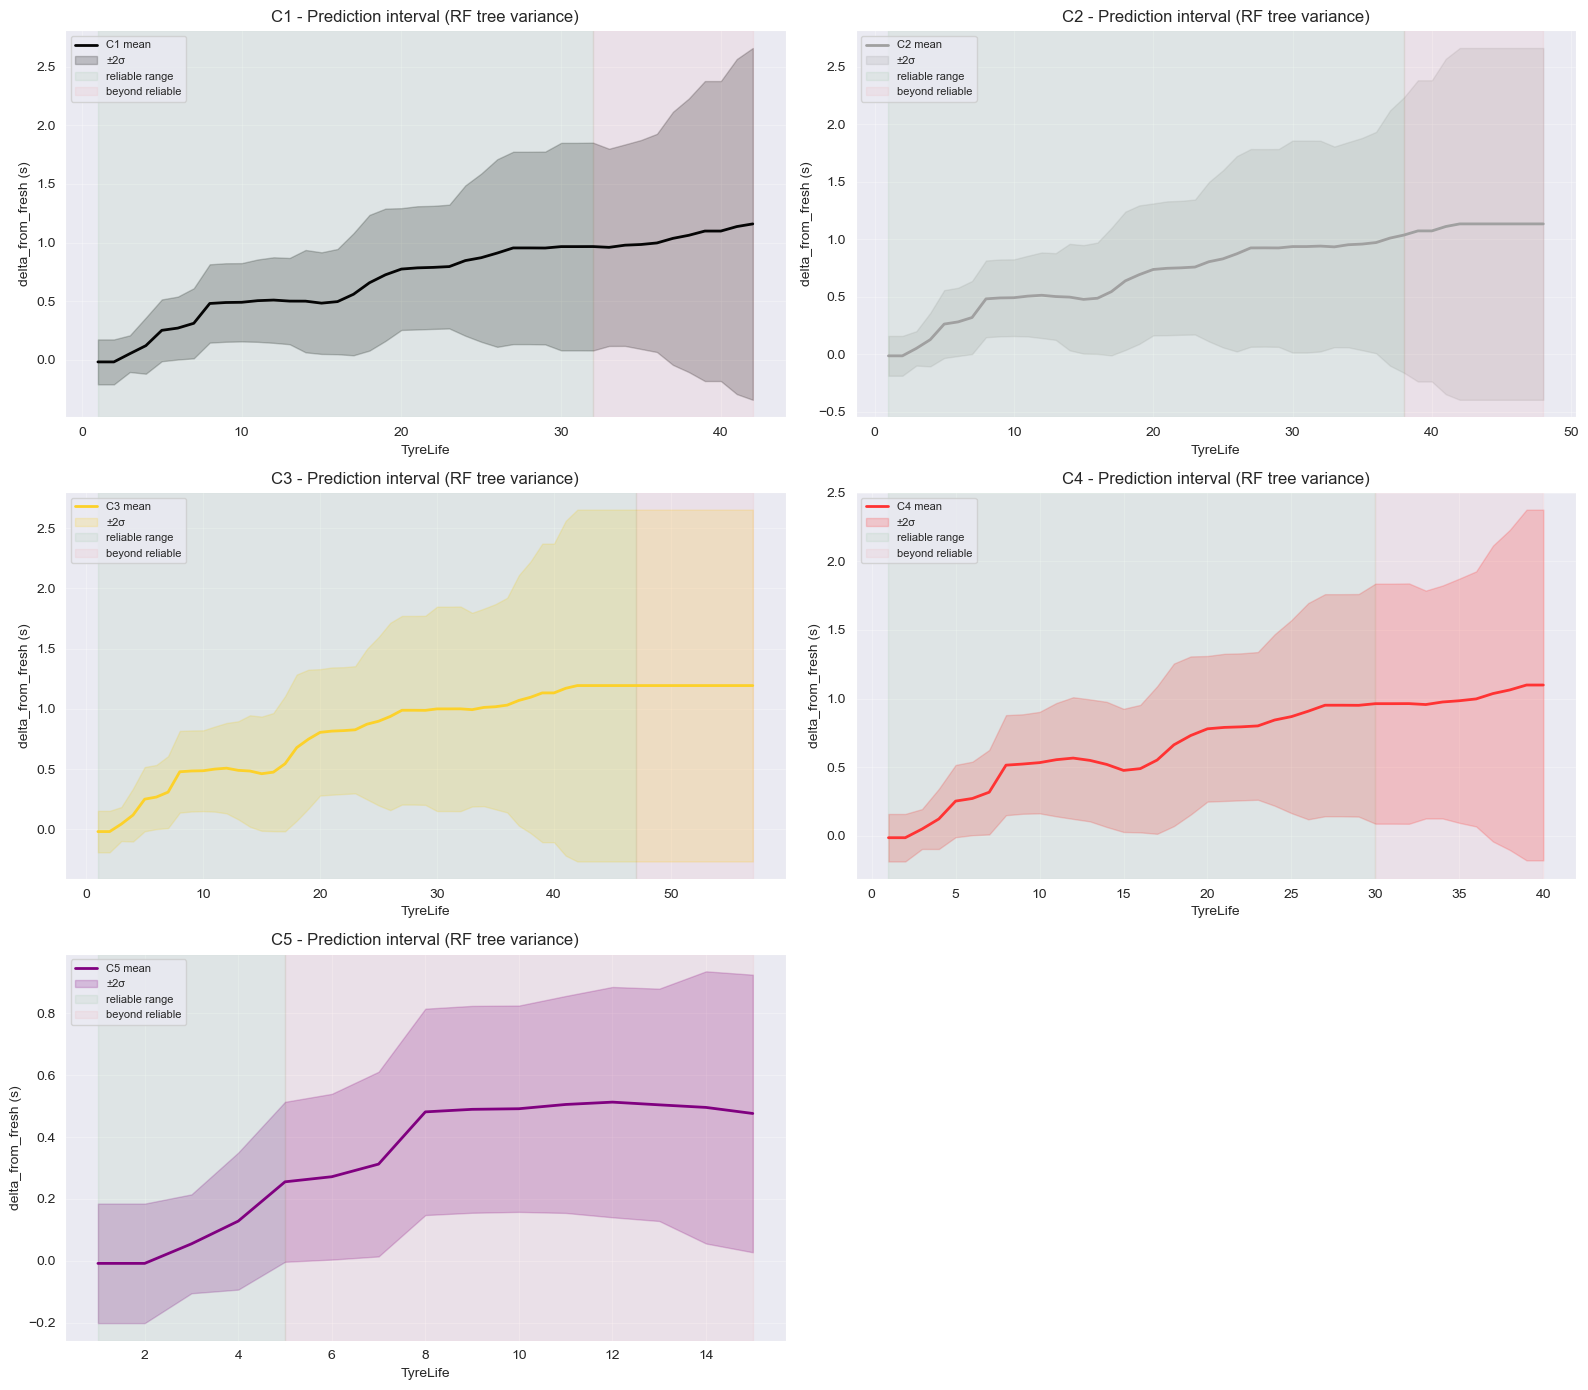

In [22]:
# %% [markdown]
# ## Section 8: Visualizations - Model Predictions
#
# 8.1 Predicted vs Actual Scatter
# 8.2 Predicted Degradation Curves (with actuals overlay)
# 8.3 Feature Importance Plot
# 8.4 Uncertainty Visualization (RF tree variance bands)

# %%
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("darkgrid")

# Guards
needed = ['general_model', 'X_test', 'y_test', 'test_df', 'feature_cols', 'X_train']
for n in needed:
    if n not in globals():
        raise RuntimeError(f"Section 8 requires '{n}'. Run Sections 3-6 first.")

# Helper to align features (reuse from Section 6 if present)
if 'align_features' not in globals():
    def align_features(X_df, expected_cols):
        X = X_df.copy()
        miss = [c for c in expected_cols if c not in X.columns]
        for c in miss:
            X[c] = 0.0
        extra = [c for c in X.columns if c not in expected_cols]
        if extra:
            X = X.drop(columns=extra)
        return X[expected_cols]

# Palette and ordering
compound_order = ['C1', 'C2', 'C3', 'C4', 'C5']
compound_colors = {
    'C1': "#050505",
    'C2': '#A0A0A0',
    'C3': '#FCD12A',
    'C4': '#FF3333',
    'C5': '#800080'
}

def color_for(comp):
    return compound_colors.get(comp, '#555555')

# Build aligned test matrix and companion meta
X_test_aligned = align_features(X_test, feature_cols)
y_pred_gen = general_model.predict(X_test_aligned)
comp_for_test = test_df.loc[X_test.index, 'exact_compound'] if ('exact_compound' in test_df.columns) else pd.Series(index=X_test.index, dtype=object)

# 8.1 Predicted vs Actual Scatter
plt.figure(figsize=(10, 8))
ax = plt.gca()
min_ax = float(min(y_test.min(), y_pred_gen.min()))
max_ax = float(max(y_test.max(), y_pred_gen.max()))
ax.plot([min_ax, max_ax], [min_ax, max_ax], color='black', linestyle='--', linewidth=1, label='Perfect (y=x)')

plot_df = pd.DataFrame({
    'actual': y_test.values,
    'pred': y_pred_gen,
    'compound': comp_for_test.values
}).dropna(subset=['actual', 'pred'])

sns.scatterplot(
    data=plot_df,
    x='actual', y='pred', hue='compound',
    hue_order=compound_order,
    palette=[compound_colors[c] for c in compound_order],
    alpha=0.3, s=20
)
plt.title('Predicted vs Actual (General Model)')
plt.xlabel('Actual delta_from_fresh (s)')
plt.ylabel('Predicted delta_from_fresh (s)')
plt.legend(title='Compound', bbox_to_anchor=(1.02, 1), loc='upper left')
plt.tight_layout()
plt.show()

# 8.2 Predicted Degradation Curves (per compound) with actual overlay
if 'engineered' not in globals() or engineered.empty:
    raise RuntimeError("Section 8 requires 'engineered' with delta_from_fresh. Run Sections 2-3 first.")

# Reliable ranges from Section 2
if 'reliable_ranges' not in globals() or not isinstance(reliable_ranges, dict):
    # fallback: compute quick reliable ranges by availability
    counts = (engineered.groupby(['exact_compound', 'TyreLife']).size().rename('n'))
    reliable_ranges = {}
    for c in compound_order:
        if c in counts.index.get_level_values(0):
            cc = counts.loc[c]
            reliable_ranges[c] = int(cc.index.max())
        else:
            reliable_ranges[c] = 0

# Base/typical conditions from training features
base_vec = X_train.median(numeric_only=True).reindex(feature_cols).fillna(0.0)

def make_grid_for_comp(comp, t_min=1, t_max=40):
    # Sweep TyreLife; assign typical medians for other features; set one-hot for this compound
    cols = feature_cols[:]
    # Identify one-hot columns
    one_hots = [c for c in cols if c.startswith('compound_')]
    comp_col = f'compound_{comp}'
    grid = []
    for t in range(t_min, t_max + 1):
        row = base_vec.copy()
        if 'TyreLife' in cols:
            row['TyreLife'] = float(t)
        # zero out all one-hots
        for oh in one_hots:
            row[oh] = 0.0
        if comp_col in cols:
            row[comp_col] = 1.0
        grid.append(row.values)
    Xg = pd.DataFrame(grid, columns=cols)
    return Xg

# Determine plotting TyreLife bounds
global_max_t = int(min(50, max(20, engineered['TyreLife'].max()))) if 'TyreLife' in engineered.columns else 35

fig, axes = plt.subplots(3, 2, figsize=(16, 14))
axes = axes.flatten()
for i, comp in enumerate(compound_order):
    ax = axes[i]
    tl_reliable = int(reliable_ranges.get(comp, 0))
    tmax = max(tl_reliable + 10, min(global_max_t, tl_reliable + 10)) if tl_reliable > 0 else min(global_max_t, 25)

    Xg = make_grid_for_comp(comp, 1, tmax)
    Xg_aligned = align_features(Xg, feature_cols)
    yg = general_model.predict(Xg_aligned)

    # Split solid (within reliable) vs dotted (beyond)
    if tl_reliable > 0:
        t_in = np.arange(1, tl_reliable + 1)
        y_in = yg[:len(t_in)]
        ax.plot(t_in, y_in, color=color_for(comp), label=f'{comp} pred (within)', linewidth=2)
        if tl_reliable < tmax:
            t_out = np.arange(tl_reliable + 1, tmax + 1)
            y_out = yg[len(t_in):]
            ax.plot(t_out, y_out, color=color_for(comp), linestyle='--', alpha=0.8, label=f'{comp} pred (beyond)')
    else:
        t_all = np.arange(1, tmax + 1)
        ax.plot(t_all, yg, color=color_for(comp), linestyle='--', label=f'{comp} pred')

    # Overlay actual data points (engineered) for this compound
    actual_c = engineered[engineered['exact_compound'] == comp][['TyreLife', 'delta_from_fresh']].dropna()
    if not actual_c.empty:
        ax.scatter(actual_c['TyreLife'], actual_c['delta_from_fresh'], color=color_for(comp), alpha=0.15, s=10, label='actual')

    ax.set_title(f"{comp} - Predicted degradation curve")
    ax.set_xlabel('TyreLife')
    ax.set_ylabel('delta_from_fresh (s)')
    ax.grid(True, alpha=0.3)
    ax.legend(loc='upper left', fontsize=8)

# Hide extra subplot if any
if len(compound_order) < len(axes):
    for j in range(len(compound_order), len(axes)):
        axes[j].axis('off')

plt.tight_layout()
plt.show()

# 8.3 Feature Importance Plot (General Model)
importances = pd.Series(general_model.feature_importances_, index=feature_cols).sort_values(ascending=True)
top_k = min(20, len(importances))
plt.figure(figsize=(10, 8))
importances.tail(top_k).plot(kind='barh', color='#3b82f6')
plt.title('Random Forest Feature Importances (Top)')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

# 8.4 Uncertainty Visualization: tree variance bands on predicted curves
# For each compound, compute mean ± 2σ across trees for the TyreLife grid under typical conditions.
fig, axes = plt.subplots(3, 2, figsize=(16, 14))
axes = axes.flatten()
n_trees = len(getattr(general_model, 'estimators_', []))

for i, comp in enumerate(compound_order):
    ax = axes[i]
    tl_reliable = int(reliable_ranges.get(comp, 0))
    tmax = max(tl_reliable + 10, min(global_max_t, tl_reliable + 10)) if tl_reliable > 0 else min(global_max_t, 25)

    Xg = make_grid_for_comp(comp, 1, tmax)
    Xg_aligned = align_features(Xg, feature_cols)

    # Collect per-tree predictions
    if n_trees > 0:
        preds_trees = np.vstack([est.predict(Xg_aligned) for est in general_model.estimators_])  # (n_trees, n_points)
        mean_pred = preds_trees.mean(axis=0)
        std_pred = preds_trees.std(axis=0)
    else:
        mean_pred = general_model.predict(Xg_aligned)
        std_pred = np.zeros_like(mean_pred)

    t_axis = np.arange(1, tmax + 1)

    # Plot mean curve
    ax.plot(t_axis, mean_pred, color=color_for(comp), linewidth=2, label=f'{comp} mean')

    # Shade uncertainty bands (±2σ)
    ax.fill_between(t_axis, mean_pred - 2*std_pred, mean_pred + 2*std_pred,
                    color=color_for(comp), alpha=0.20, label='±2σ')

    # Indicate reliable vs beyond area by background span or style
    if tl_reliable > 0:
        ax.axvspan(1, tl_reliable, color='green', alpha=0.05, label='reliable range')
        if tl_reliable < tmax:
            ax.axvspan(tl_reliable, tmax, color='red', alpha=0.04, label='beyond reliable')

    ax.set_title(f"{comp} - Prediction interval (RF tree variance)")
    ax.set_xlabel('TyreLife')
    ax.set_ylabel('delta_from_fresh (s)')
    ax.grid(True, alpha=0.3)

    # Keep legend compact
    handles, labels = ax.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    ax.legend(by_label.values(), by_label.keys(), loc='upper left', fontsize=8)

# Hide extra subplot if any
if len(compound_order) < len(axes):
    for j in range(len(compound_order), len(axes)):
        axes[j].axis('off')

plt.tight_layout()
plt.show()

In [24]:
# %% [markdown]
# ## Section 9: Interpretation & Explanation
# 
# 9.1 Counterintuitive Results (compound total vs observed range)  
# 9.2 What the Model Learned (grouped importances)  
# 9.3 Limitations & Reliability Summary  

# %%
import numpy as np
import pandas as pd

# Guard checks
if 'engineered' not in globals() or engineered.empty:
    raise RuntimeError("Engineered dataset missing.")
if 'general_model' not in globals():
    raise RuntimeError("Model missing.")
if 'reliable_ranges' not in globals():
    reliable_ranges = {}

# 9.1 Degradation rate (simple slope within reliable range)
deg_rows = []
for comp, max_t in reliable_ranges.items():
    comp_df = engineered[engineered['exact_compound'] == comp]
    if comp_df.empty or max_t <= 3:
        continue
    use_df = comp_df[comp_df['TyreLife'] <= max_t]
    # Aggregate by TyreLife (mean reduces stint noise)
    agg = (use_df.groupby('TyreLife')['delta_from_fresh']
                 .mean()
                 .reset_index()
                 .sort_values('TyreLife'))
    if len(agg) < 4:
        continue
    x = agg['TyreLife'].values
    y = agg['delta_from_fresh'].values
    # Linear fit
    slope, intercept = np.polyfit(x, y, 1)
    deg_rows.append({'compound': comp,
                     'max_observed_tyre_life': max_t,
                     'samples': len(use_df),
                     'linear_slope_s_per_lap': slope,
                     'intercept': intercept,
                     'delta_at_max': y[-1]})

degradation_rates = pd.DataFrame(deg_rows).sort_values('compound')
print("🔎 Degradation rate (linear slope within reliable range):")
print(degradation_rates)

print("\n📝 Counterintuitive explanation hint:")
print("Harder compounds appear to 'degrade more' because they are observed over longer ranges.")
print("Compare delta_at_max only within observed windows, not extrapolated.")

# 9.2 Feature importance grouping
importances = pd.Series(general_model.feature_importances_, index=feature_cols)

groups = {
    'TyreLife': [c for c in feature_cols if c == 'TyreLife'],
    'Environment': [c for c in feature_cols if c in ['TrackTemp', 'AirTemp', 'dirty_air']],
    'Circuit_Grip_Wear': [c for c in feature_cols if c in ['Asphalt Grip', 'Asphalt Abrasion', 'Track Evolution']],
    'Circuit_Load': [c for c in feature_cols if c in ['Tyre Stress', 'Lateral', 'Downforce', 'Traction', 'Breaking']],
    'Lap_Length': [c for c in feature_cols if c in ['Lap Length']],
    'Compound One-Hots': [c for c in feature_cols if c.startswith('compound_')]
}

group_rows = []
for g, cols in groups.items():
    if not cols:
        continue
    group_rows.append({'group': g,
                       'features': len(cols),
                       'importance_sum': importances[cols].sum(),
                       'importance_mean': importances[cols].mean() if len(cols) else 0.0})
group_importances = pd.DataFrame(group_rows).sort_values('importance_sum', ascending=False)
print("\n📊 Grouped feature importances:")
print(group_importances)

print("\nTop individual features:")
print(importances.sort_values(ascending=False).head(10))

# 9.3 Limitations summary
limits_df = pd.DataFrame([
    {'compound': c,
     'max_reliable_tyre_life': reliable_ranges.get(c, 0),
     'available_samples': int(engineered[engineered['exact_compound'] == c].shape[0])}
    for c in sorted(reliable_ranges.keys())
])
print("\n🛑 Reliability matrix:")
print(limits_df)

print("\n⚠️ Limitations:")
print("- Predictions beyond max_reliable_tyre_life shown as dashed / high uncertainty.")
print("- Noise high: low R² expected; use slopes for relative comparison.")
print("- Circuit effects learned only where data present; sparse circuits reduce confidence.")
print("- No extrapolation: model grids beyond observed ranges are illustrative only.")

# %% [markdown]
# ## Section 10: Outputs & Artifacts
# 
# 10.1 Save model & metadata  
# 10.2 Export processed data & predictions with intervals  
# 10.3 Generate markdown report  

# %%
import os
import json
from pathlib import Path
from joblib import dump

artifacts_dir = Path("artifacts")
artifacts_dir.mkdir(exist_ok=True)

# 10.1 Save model + metadata
dump(general_model, artifacts_dir / "general_random_forest.joblib")
with open(artifacts_dir / "feature_list.json", "w") as f:
    json.dump(feature_cols, f, indent=2)
with open(artifacts_dir / "reliable_ranges.json", "w") as f:
    json.dump(reliable_ranges, f, indent=2)

# 10.2 Export engineered training data (subset columns)
save_cols = ['Driver', 'EventName', 'TyreLife', 'exact_compound',
             'delta_from_fresh', 'dirty_air', 'TrackTemp', 'AirTemp']
present_save_cols = [c for c in save_cols if c in engineered.columns]
engineered[present_save_cols].to_csv(artifacts_dir / "engineered_data.csv", index=False)

# Predictions with uncertainty on test set
if 'X_test' in globals() and len(X_test):
    X_test_aligned = align_features(X_test, feature_cols)
    tree_preds = np.vstack([est.predict(X_test_aligned) for est in general_model.estimators_])
    mean_pred = tree_preds.mean(axis=0)
    std_pred = tree_preds.std(axis=0)
    ci_lower = mean_pred - 1.96 * std_pred
    ci_upper = mean_pred + 1.96 * std_pred
    meta_cols = ['TyreLife', 'exact_compound']
    meta_present = [c for c in meta_cols if c in test_df.columns]
    pred_out = test_df.loc[X_test.index, meta_present].copy()
    pred_out['actual'] = y_test.values
    pred_out['pred_mean'] = mean_pred
    pred_out['pred_std'] = std_pred
    pred_out['pred_lower95'] = ci_lower
    pred_out['pred_upper95'] = ci_upper
    pred_out.to_csv(artifacts_dir / "test_predictions_with_ci.csv", index=False)
else:
    print("⚠️ Test set missing; skipping prediction export.")

# 10.3 Report
# Recompute core metrics
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
if 'X_test' in globals() and len(X_test):
    X_test_aligned = align_features(X_test, feature_cols)
    y_pred_rep = general_model.predict(X_test_aligned)
    r2_rep = r2_score(y_test, y_pred_rep)
    rmse_rep = mean_squared_error(y_test, y_pred_rep, squared=False)
    mae_rep = mean_absolute_error(y_test, y_pred_rep)
else:
    r2_rep = rmse_rep = mae_rep = np.nan

# Per-compound metrics
per_comp_metrics = []
if 'test_df' in globals() and not test_df.empty:
    for comp in sorted(test_df['exact_compound'].dropna().unique()):
        comp_rows = test_df[test_df['exact_compound'] == comp]
        if comp_rows.empty:
            continue
        Xc, yc, _ = build_feature_matrix(comp_rows)
        Xc_aligned = align_features(Xc, feature_cols)
        yhat_c = general_model.predict(Xc_aligned)
        per_comp_metrics.append({
            'compound': comp,
            'n_test_laps': len(comp_rows),
            'r2': r2_score(yc, yhat_c),
            'rmse': mean_squared_error(yc, yhat_c, squared=False),
            'mae': mean_absolute_error(yc, yhat_c)
        })
per_comp_df = pd.DataFrame(per_comp_metrics)

report_lines = []
report_lines.append("# F1 Tire Degradation - Data-Driven Model Report")
report_lines.append("## Overview")
report_lines.append(f"General Model Metrics (test set): R2={r2_rep:.3f}, RMSE={rmse_rep:.3f}s, MAE={mae_rep:.3f}s")
report_lines.append("## Reliability Ranges")
report_lines.append(limits_df.to_markdown(index=False))
report_lines.append("## Degradation Slopes (s per lap)")
if not degradation_rates.empty:
    report_lines.append(degradation_rates[['compound','linear_slope_s_per_lap','delta_at_max','max_observed_tyre_life']].to_markdown(index=False))
else:
    report_lines.append("_No slope data available._")
report_lines.append("## Per-Compound Metrics")
if not per_comp_df.empty:
    report_lines.append(per_comp_df.to_markdown(index=False))
else:
    report_lines.append("_No per-compound test metrics available._")
report_lines.append("## Top Feature Importances")
top_feats = importances.sort_values(ascending=False).head(15)
report_lines.append(top_feats.to_frame('importance').to_markdown())
report_lines.append("## Grouped Importances")
report_lines.append(group_importances.to_markdown(index=False))
report_lines.append("## Interpretation")
report_lines.append("- Longer observed stints inflate total delta for harder compounds.")
report_lines.append("- TyreLife dominates; circuit load features have secondary influence.")
report_lines.append("- dirty_air contributes but less than intrinsic tyre wear + circuit stress.")
report_lines.append("## Limitations")
report_lines.append("- Low signal-to-noise; modest R2 expected.")
report_lines.append("- No extrapolation beyond reliable ranges (dashed in plots).")
report_lines.append("- Feature importances can shift with additional races.")
report_lines.append("- Random Forest variance used as proxy; not full predictive uncertainty.")
report_lines.append("## Artifacts")
report_lines.append("- Model: general_random_forest.joblib")
report_lines.append("- Features: feature_list.json")
report_lines.append("- Reliability: reliable_ranges.json")
report_lines.append("- Engineered data: engineered_data.csv")
report_lines.append("- Predictions with CI: test_predictions_with_ci.csv")
report_path = artifacts_dir / "report.md"
with open(report_path, "w") as f:
    f.write("\n\n".join(report_lines))
print(f"📄 Report written to {report_path}")

# Minimal confirmation outputs
print("✅ Section 10 artifacts saved.")

🔎 Degradation rate (linear slope within reliable range):
  compound  max_observed_tyre_life  samples  linear_slope_s_per_lap  \
0       C1                      32     2742                0.063617   
1       C2                      38     3761               -0.019094   
2       C3                      47    10295               -0.004928   
3       C4                      30     4506                0.015996   
4       C5                       5       87                0.151879   

   intercept  delta_at_max  
0  -0.308762      1.332467  
1   0.392446     -1.496524  
2   0.419036     -1.277780  
3   0.030661      0.034415  
4  -0.318488      0.439386  

📝 Counterintuitive explanation hint:
Harder compounds appear to 'degrade more' because they are observed over longer ranges.
Compare delta_at_max only within observed windows, not extrapolated.

📊 Grouped feature importances:
               group  features  importance_sum  importance_mean
1        Environment         3        0.283552     

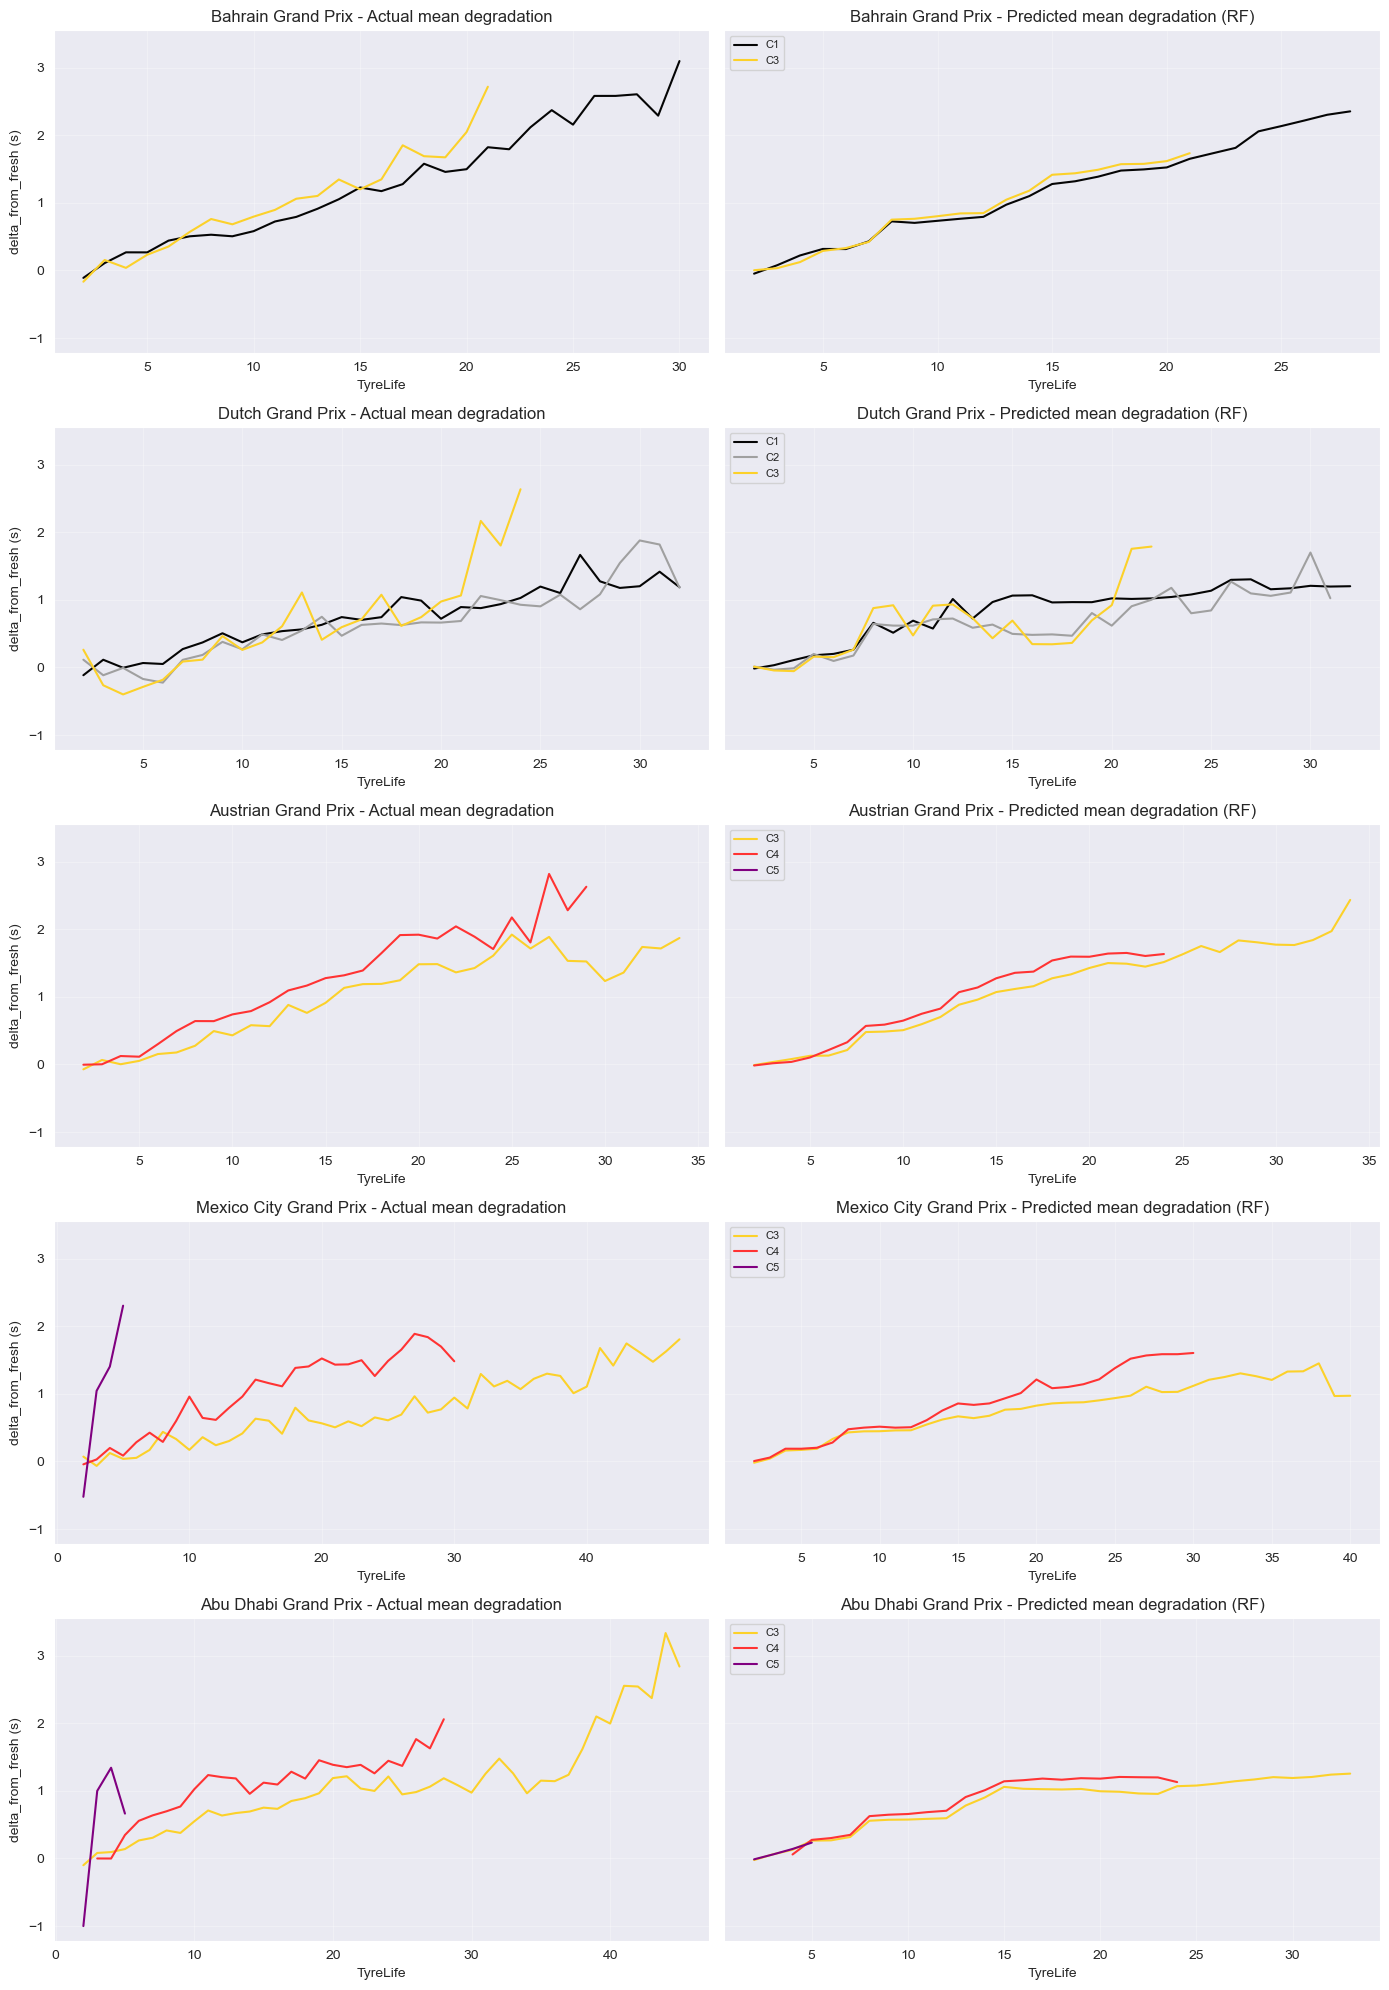

Circuit comparison (slopes and deltas):
                     event compound  actual_slope_s_per_lap  \
0       Bahrain Grand Prix       C1                0.102209   
1       Bahrain Grand Prix       C2                     NaN   
2       Bahrain Grand Prix       C3                0.121403   
3       Bahrain Grand Prix       C4                     NaN   
4       Bahrain Grand Prix       C5                     NaN   
5         Dutch Grand Prix       C1                0.047471   
6         Dutch Grand Prix       C2                0.053981   
7         Dutch Grand Prix       C3                0.098156   
8         Dutch Grand Prix       C4                     NaN   
9         Dutch Grand Prix       C5                     NaN   
10     Austrian Grand Prix       C1                     NaN   
11     Austrian Grand Prix       C2                     NaN   
12     Austrian Grand Prix       C3                0.061346   
13     Austrian Grand Prix       C4                0.096265   
14     Austrian

In [26]:
# %% [markdown]
# ## Section 9A: Circuit-level comparison (Predicted vs Real)
# Compare predicted degradation vs actual on selected circuits:
# Bahrain, Dutch (Netherlands), Austrian, Mexico City, Abu Dhabi.

# %%
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("darkgrid")

# Guards
required_vars = ['engineered', 'test_df', 'general_model', 'feature_cols', 'X_test']
for v in required_vars:
    if v not in globals():
        raise RuntimeError(f"Missing '{v}'. Run previous sections.")

# Helper from validation to align features
def _align_features_local(X_df, expected_cols):
    X = X_df.copy()
    for c in expected_cols:
        if c not in X.columns:
            X[c] = 0.0
    drop_cols = [c for c in X.columns if c not in expected_cols]
    if drop_cols:
        X = X.drop(columns=drop_cols)
    return X[expected_cols]

# Selected events (FastF1 names must match engineered/test_df['EventName'])
selected_events = [
    'Bahrain Grand Prix',
    'Dutch Grand Prix',
    'Austrian Grand Prix',
    'Mexico City Grand Prix',
    'Abu Dhabi Grand Prix'
]

# Build comparison data per event:
# - Aggregate actual mean delta_from_fresh by TyreLife and compound
# - Predict under observed rows conditions to get predicted mean by TyreLife and compound
compounds = ['C1', 'C2', 'C3', 'C4', 'C5']
palette = {
    'C1': "#050505",
    'C2': '#A0A0A0',
    'C3': '#FCD12A',
    'C4': '#FF3333',
    'C5': '#800080'
}

# Create faceted plots: each event has two panels (actual vs predicted)
events_available = [e for e in selected_events if e in engineered['EventName'].unique()]
if not events_available:
    print("⚠️ None of the selected events are present in the dataset.")
else:
    n_events = len(events_available)
    fig, axes = plt.subplots(n_events, 2, figsize=(14, 4 * n_events), sharex=False, sharey=True)
    if n_events == 1:
        axes = np.array([axes])  # ensure 2D

    for i, event in enumerate(events_available):
        # Actual aggregation from engineered (uses fuel-corrected + baseline target)
        actual_ev = engineered[(engineered['EventName'] == event) &
                               (engineered['exact_compound'].isin(compounds))].copy()
        actual_ev = actual_ev.dropna(subset=['TyreLife', 'delta_from_fresh'])
        actual_agg = (actual_ev
                      .groupby(['exact_compound', 'TyreLife'])['delta_from_fresh']
                      .mean()
                      .reset_index())

        # Predicted: use rows from test_df for the same event (to avoid leakage) if present,
        # otherwise use engineered rows to build feature matrix
        source_ev = test_df[test_df['EventName'] == event].copy()
        if source_ev.empty:
            source_ev = engineered[engineered['EventName'] == event].copy()

        # Build features and predict per row, then aggregate mean by (compound, TyreLife)
        X_ev, y_ev, _ = build_feature_matrix(source_ev)
        X_ev_aligned = _align_features_local(X_ev, feature_cols)
        yhat_ev = general_model.predict(X_ev_aligned)
        pred_df = source_ev[['exact_compound', 'TyreLife']].copy()
        pred_df['pred'] = yhat_ev
        pred_agg = (pred_df
                    .groupby(['exact_compound', 'TyreLife'])['pred']
                    .mean()
                    .reset_index())

        # Plot actual
        ax_actual = axes[i, 0]
        for comp in compounds:
            a = actual_agg[actual_agg['exact_compound'] == comp]
            if a.empty:
                continue
            ax_actual.plot(a['TyreLife'], a['delta_from_fresh'], label=comp, color=palette[comp])
        ax_actual.set_title(f"{event} - Actual mean degradation")
        ax_actual.set_xlabel("TyreLife")
        ax_actual.set_ylabel("delta_from_fresh (s)")
        ax_actual.grid(True, alpha=0.3)

        # Plot predicted
        ax_pred = axes[i, 1]
        for comp in compounds:
            p = pred_agg[pred_agg['exact_compound'] == comp]
            if p.empty:
                continue
            ax_pred.plot(p['TyreLife'], p['pred'], label=comp, color=palette[comp])
        ax_pred.set_title(f"{event} - Predicted mean degradation (RF)")
        ax_pred.set_xlabel("TyreLife")
        ax_pred.grid(True, alpha=0.3)

        # Shared legend once per row
        handles, labels = ax_pred.get_legend_handles_labels()
        if handles:
            ax_pred.legend(loc='upper left', fontsize=8)

    plt.tight_layout()
    plt.show()

# Tabular comparison: per event and compound, compute slope (s/lap) within observed TyreLife window
rows = []
for event in events_available:
    # Use aggregated actual and predicted built above again
    ev_eng = engineered[(engineered['EventName'] == event) &
                        (engineered['exact_compound'].isin(compounds))].copy()
    ev_eng = ev_eng.dropna(subset=['TyreLife', 'delta_from_fresh'])

    ev_src = test_df[test_df['EventName'] == event].copy()
    if ev_src.empty:
        ev_src = engineered[engineered['EventName'] == event].copy()

    X_ev, y_ev, _ = build_feature_matrix(ev_src)
    X_ev_aligned = _align_features_local(X_ev, feature_cols)
    yhat_ev = general_model.predict(X_ev_aligned)

    pred_rows = ev_src[['exact_compound', 'TyreLife']].copy()
    pred_rows['pred'] = yhat_ev

    for comp in compounds:
        a = (ev_eng[ev_eng['exact_compound'] == comp]
             .groupby('TyreLife')['delta_from_fresh'].mean().reset_index().sort_values('TyreLife'))
        p = (pred_rows[pred_rows['exact_compound'] == comp]
             .groupby('TyreLife')['pred'].mean().reset_index().sort_values('TyreLife'))
        if len(a) >= 4:
            sa, ia = np.polyfit(a['TyreLife'], a['delta_from_fresh'], 1)
        else:
            sa, ia = (np.nan, np.nan)
        if len(p) >= 4:
            sp, ip = np.polyfit(p['TyreLife'], p['pred'], 1)
        else:
            sp, ip = (np.nan, np.nan)
        rows.append({
            'event': event,
            'compound': comp,
            'actual_slope_s_per_lap': sa,
            'pred_slope_s_per_lap': sp,
            'actual_delta_at_maxTL': a['delta_from_fresh'].iloc[-1] if len(a) else np.nan,
            'pred_delta_at_maxTL': p['pred'].iloc[-1] if len(p) else np.nan,
            'maxTL_actual': a['TyreLife'].max() if len(a) else np.nan,
            'maxTL_pred': p['TyreLife'].max() if len(p) else np.nan
        })

compare_df = pd.DataFrame(rows)
print("Circuit comparison (slopes and deltas):")
print(compare_df.dropna(how='all'))